# Diversity and stereotypy at the synaptic structure level

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import math
import os
import pickle

import multiprocessing as mp
from pandas.plotting import parallel_coordinates
import umap
import sklearn
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy import stats
plt.style.use(['science', 'no-latex'])

import neuro_morpho_toolbox as nmt
import neuro_morpho_toolbox.plot as nmtp
from sklearn.preprocessing import StandardScaler
import pymrmr
from matplotlib.ticker import MaxNLocator
from math import pi

def reassign_region_id():
    region_used=nmt.bs.selected_regions
    origin_ccf = np.array(nmt.annotation.array[:, :, :], dtype=np.uint32)
    selected_annotaion = np.zeros_like(nmt.annotation.array, dtype=np.uint32)
    for region in region_used:
        #get its child region
        child_regions = nmt.bs.get_all_child_id(region)
        if len(child_regions) == 0:
            ix, iy, iz = np.where(origin_ccf == region)
            selected_annotaion[ix, iy, iz] = region
            continue
        for childregion in child_regions:
            ix, iy, iz = np.where(origin_ccf == childregion)
            selected_annotaion[ix, iy, iz] = region
    print('processing finished, reassign region id to its parent_id')
    return selected_annotaion

def get_region_swc(cswc,
                   annotation=nmt.annotation,
                   brain_structure=nmt.bs,
                   region_used=None,
                   scale=25):
    tp = cswc.copy()
    tp = pd.DataFrame(
        {
            "x": np.array(np.array(tp.x)/scale,dtype="int32"),
            "y": np.array(np.array(tp.y)/scale,dtype="int32"),
            "z": np.array(np.array(tp.z)/scale,dtype="int32")
        },
        index=tp.index)
    tp = tp[((tp.x >= 0) & (tp.x < annotation.size['x']) & (tp.y >= 0) &
             (tp.y < annotation.size['y']) & (tp.z >= 0) &
             (tp.z < annotation.size['z']))]

    # Add region id to the dataframe
    if region_used is None:
        region_used = nmt.bs.selected_regions
        dict_to_used = nmt.bs.dict_to_selected
    else:
        assert all([
            (i in brain_structure.level.index.tolist()) for i in region_used
        ]), "Given regions invalid. Please check 'region_used'."
        dict_to_used = {}
        for cur_region in region_used:
            child_ids = nmt.bs.get_all_child_id(cur_region)
            for i in child_ids:
                dict_to_used[i] = cur_region
    tp["region_id"] = np.array(annotation.array[tp.x, tp.y, tp.z], dtype=int)
    tp = tp[tp.region_id.isin(list(dict_to_used.keys()))]
    tp["region_id"] = np.array(tp["region_id"].map(dict_to_used), dtype=int)
    res = cswc.copy()
    res['region_id'] = 0
    res.loc[tp.index, 'region_id'] = tp['region_id']
    return res

def get_soma_region(infile):
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return 'error'
    soma=inswc[inswc.parent<0].copy()
    somar=get_region_swc(cswc=soma,annotation=my_annotation)
    soma_rid=somar['region_id'].tolist()[0]
    if soma_rid >0:
        return nmt.bs.id_to_name(soma_rid)
    return 'error'

ccf_reassigned_f='/Users/jiangshengdian/Desktop/Daily/PhD_project/Platform/motif/ccf_reassigned.pickle'
if os.path.exists(ccf_reassigned_f):
    with open(ccf_reassigned_f,'rb') as f:
        my_annotation=pickle.load(f)
else:
    print('reassign start... will take a long time.')
    selected_annotaion=reassign_region_id()
    my_annotation=nmt.annotation
    my_annotation.array=selected_annotaion
    with open(ccf_reassigned_f,'wb') as f:
        pickle.dump(my_annotation,f)

TH=['AD','AM','AV','CL','CM','IAD','LD','LGd','LHA','LP','MD','MG','MM','PCN','PF','PIL','PO','POL','PR','PVT','PoT','RE','RT','SGN','SMT','TH','VAL','VM','VPL','VPLpc','VPM','VPMpc']
CTX=['ACAd','ACAv','AId','AIp','AIv','AON','AON','AUDd','AUDpo','AUDv','BLA','BMA','CA1','CA3','CLA','COAp','HPF','DG','ECT','ENTl','ENTm','EPd','FRP','GU','IG','ILA','MOB','MOp','MOs','ORBl','ORBm','ORBvl','PIR','PL','POST','PRoS',
    'RSPagl','RSPd','RSPv','SSs','SUB','TEa','TR','VISC','VISa','VISal','VISam','VISl','VISli','VISp','VISpm','VISpor','VISrl','SSp','SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un']
CNU=['ACB','BST','CEA','CP','FS','GPe','GPi','LSr','LSv','OT','PAL','PAR','PRE','SI']
HY=['AHN','DMH','HY','PH','PSTN','PVH','PVi','PeF','SBPV','TU','VMH','ZI']
CB=['CENT','COPY','CUL','DEC','FL','FN','FOTU','NOD','PFL','AN','PRM','PYR','SIM']
MB=['DR','IC','MB','MRN','MV','MY','PAG','RN','SNc']
HB=['IRN','LRN','MDRNd','MDRNv','P','PARN','PB','PG','PGRNl','PRNc','PRNr','PSV','SPIV','SPVC','SPVO','SUV','TRN','V','VCO']
btype=['CNU','TH','CTX']
bcolors=['#75bbfd','#029386','#ff796c']
cnu_stypes=['CP','OT']
th_stypes=['VPM','VPL','LGd','LP','VPLpc','MG', 'RT']
ctx_stypes=['MOp', 'MOs','SSp','SSs','AId', 'RSPv', 'CLA']
ana_regions=['CP','OT','VPM','VPL','LGd','LP','VPLpc','MG', 'RT','SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n', 'SSp-un','MOp', 'MOs','SSs', 'AId', 'RSPv', 'CLA']
ana_stypes=['CP','OT','VPM','VPL','LGd','LP','VPLpc','MG', 'RT','SSp','MOp', 'MOs','SSs', 'AId', 'RSPv', 'CLA']
ssp_regions=['SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n', 'SSp-un']
morpho_feas=pd.read_csv('../fullmorpho/py/ana_lm_statistics_full.csv',index_col=['name'])
usedfeas=['type','x','y','z','radius','parent','level']
swc_fea_list=['ccfx','ccfy','ccfz','ccfr','btype','bdist','neighborb','dist2soma','edist2soma','nearbdist','node_contraction']
sheader=['##n','type','x','y','z','radius','parent','bdist','neighborb','dist2soma','edist2soma','nearbdist','node_contraction']
rheader=['n','type','x','y','z','radius','parent','bdist','neighborb','dist2soma','edist2soma','nearbdist','node_contraction']
bswcdata='./bfeas'
out_fea_path='ccf_bfea'

In [2]:
def saveswc(inswc,tofile,scale=1,retype=None,xshift=0,flip=False,header=None):
    swc=inswc.copy()
    if header is None:
        header=['##n','type','x','y','z','radius','parent']
    if retype is not None:
        swc['type']=retype
    if scale != 1 and scale >0:
        swc['x']/=scale
        swc['y']/=scale
        swc['z']/=scale
        if xshift:
            swc['x']+=xshift
        soma=swc[swc.parent<0].copy()
        soma=soma.iloc[0]
        sz=soma['z']
        if flip and sz > nmt.annotation.size['z']/2:
            # print('flip')
            swc['z']= nmt.annotation.size['z'] - swc['z']
    swc.reset_index(inplace=True)
    if swc.shape[1] != len(header):
        print('Input SWC header not match!!!')
        header=swc.keys().to_list()
        header[0]='##'+header[0]
    swc.to_csv(tofile,sep=' ',index=0,header=header)
    # return swc
def get_degree(tswc):
    tswc['degree'] = tswc['parent'].isin(tswc.index).astype('int')
    # print(tswc['degree'])
    n_child = tswc.parent.value_counts()
    n_child = n_child[n_child.index.isin(tswc.index)]
    tswc.loc[n_child.index, 'degree'] = tswc.loc[n_child.index, 'degree'] + n_child
    return tswc
def get_rid(swc):
    '''
    Find root node.
    '''
    rnode=swc[((swc['parent']<0) & (swc['type']<=1))]
    if rnode.shape[0]<1:
        return -1
    return rnode.index[0]
def get_keypoint(inswc, rid=None):
    swc=inswc.copy()
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    idlist = swc[((swc.degree!=2) | (swc.index==rid))].index.tolist()
    return idlist
def swc2branches(swc):
    '''
    reture branch list of a swc
    branch: down to top
    '''
    keyids=get_keypoint(swc)
    branches=[]
    for key in keyids:
        if swc.loc[key,'parent']<0 | swc.loc[key,'type']<=1:
            continue
        branch=[]
        branch.append(key)
        pkey=swc.loc[key,'parent']
        while True:
            branch.append(pkey)
            if pkey in keyids:
                break
            key=pkey
            pkey=swc.loc[key,'parent']
        branches.append(branch)
    return branches
def get_tips(swc, rid=None, ntype = None):
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    if ntype is not None:
        idlist = swc[(swc.degree<2) & (swc.type == ntype) ].index.tolist()
    else:
        idlist = swc[(swc.degree<2)].index.tolist()
    return idlist
def get_brpoints(swc, rid=None, ntype=None):
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    if ntype is not None:
        idlist = swc[((swc.degree>2) & (swc.index!=rid) & (swc.type == ntype))].index.tolist()
    else:
        idlist = swc[((swc.degree>2) & (swc.index!=rid))].index.tolist()
    return idlist
def nodes_dis(swc,n1,n2):
    if n1 not in swc.index or n2 not in swc.index:
        return None
    x1=swc.loc[n1,'x']
    y1=swc.loc[n1,'y']
    z1=swc.loc[n1,'z']
    x2=swc.loc[n2,'x']
    y2=swc.loc[n2,'y']
    z2=swc.loc[n2,'z']
    return math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2))
def readswc(file,out_fea=None,fea_val_names=None,header=None,skiprows=3):
    swc=pd.read_csv(file,sep=' ',header=None,skiprows=skiprows)
    if header is None:
        header=['n','type','x','y','z','radius','parent']
        if swc.shape[1] >= 12:
            header+=['seg_id','level','mode','timestamp','teraflyindex']
            for i in np.arange(12,swc.shape[1]):
                if fea_val_names is not None:
                    header.append(fea_val_names[i-12])
                else:
                    header.append('fea_'+str(i-12))
    if len(header) == swc.shape[1]:
        swc.columns=header
    swc.set_index(['n'],drop=True,inplace=True)
    if out_fea is None:
        return swc
    else:
        return swc[out_fea]
def bswc2ccf(inswc,scale=1,ignore_dendrite=False):
    if ignore_dendrite:
        swc=inswc[(inswc.type !=4) & (inswc.type !=3)].copy()
    else:
        swc=inswc.copy()
    swc=swc[['type','parent','ccfx', 'ccfy', 'ccfz', 'ccfr', 'btype',
       'bdist', 'neighborb', 'dist2soma', 'edist2soma','nearbdist','node_contraction']].copy()
    swc['x']=round(swc['ccfx']/scale,2)
    swc['y']=round(swc['ccfy']/scale,2)
    swc['z']=round(swc['ccfz']/scale,2)
    swc['r']=round(swc['ccfr']/scale,4)
    swc.loc[swc.btype==3,'type']=6
    swc['dist2soma']=round(swc['dist2soma'],2)
    swc['edist2soma']=round(swc['edist2soma'],2)
    swc['nearbdist']=round(swc['nearbdist'],2)
    swc['node_contraction']=round(swc['node_contraction'],4)
    return swc[['type','x', 'y', 'z', 'r','parent',
       'bdist', 'neighborb', 'dist2soma', 'edist2soma','nearbdist','node_contraction']]
def node_dist2soma(swc,nid):
    rid=get_rid(swc)
    dist=0
    key=nid
    pkey=swc.loc[key,'parent']
    while True:
        dist+=nodes_dis(swc,key,pkey)
        if pkey == rid:
            break
        key=pkey
        pkey=swc.loc[key,'parent']
    return dist
def dist2soma(swc):
    swc['dist2soma']=-1
    rid=get_rid(swc)
    for nid in swc.index:
        if rid == nid:
            swc.loc[nid,'dist2soma']=0
            continue
        dist=0
        key=nid
        pkey=swc.loc[key,'parent']
        while True:
            if swc.loc[pkey,'dist2soma'] >=0:
                dist+=swc.loc[pkey,'dist2soma']
                break
            dist+=nodes_dis(swc,key,pkey)
            if pkey == rid:
                break
            key=pkey
            pkey=swc.loc[key,'parent']
        swc.loc[nid,'dist2soma']=dist
def b_dist2soma(swc,path=False):
    if path:
        swc['pdist2soma']=-1
    else:
        swc['edist2soma']=-1
    rid=get_rid(swc)
    keyids=swc[swc.type>=5].index.to_list()
    for nid in keyids:
        if rid == nid:
            continue
        dist=0
        if path:
            key=nid
            pkey=swc.loc[key,'parent']
            while True:
                if swc.loc[pkey,'pdist2soma'] >=0:
                    dist+=swc.loc[pkey,'pdist2soma']
                    break
                dist+=nodes_dis(swc,key,pkey)
                if pkey == rid:
                    break
                key=pkey
                pkey=swc.loc[key,'parent']
        else:
            dist=nodes_dis(swc,rid,nid)
        if path:
            swc.loc[nid,'pdist2soma']=dist
        else:
            swc.loc[nid,'edist2soma']=dist
def b_interval(swc,bouton_type=5):
    '''what is bouton interval:
    (small) distance to near bouton along axonal path
    get distance to its parent bouton
    '''
    # swc=indata.copy()
    rid=get_rid(swc)
    swc['bdist2pb']=-1
    swc['bdist2cb']=-1
    for bid in swc[swc.type==bouton_type].index:
        key=bid
        pkey=swc.loc[key,'parent']
        swc.loc[key,'bdist2pb']=0
        swc.loc[pkey,'bdist2cb']=0
        dist=0
        while True:
            dist+=nodes_dis(swc,key,pkey)
            if pkey in swc[swc.type==bouton_type].index:
                swc.loc[bid,'bdist2pb']=dist
                swc.loc[pkey,'bdist2cb']=dist
                break
            if pkey == rid:
                swc.loc[bid,'bdist2pb']=dist
                break
            key=pkey
            pkey=swc.loc[key,'parent']
    swc.loc['binterval']=-1
    for bid in swc[swc.type==bouton_type].index:
        if swc.loc[bid,'bdist2cb'] <= 0:
            swc.loc[bid,'binterval']=swc.loc[bid,'bdist2pb']
        else:
            swc.loc[bid,'binterval']=swc.loc[bid,'bdist2pb'] if swc.loc[bid,'bdist2pb'] < swc.loc[bid,'bdist2cb'] else swc.loc[bid,'bdist2cb']
    swc.drop(['bdist2pb','bdist2cb'],axis=1,inplace=True)
def b_type(swc,teb_len_thre=5,bouton_type=5):
    swc['btype']='None'
    brs=get_brpoints(swc)
    tips=get_tips(swc)
    rid=get_rid(swc)
    for bid in swc[swc.type==bouton_type].index:
        swc.loc[bid,'btype']='EPB'
        if bid not in tips:
            continue
        dist=0
        key=bid
        # print(bid)
        pkey=swc.loc[key,'parent']
        while True:
            dist+=nodes_dis(swc,key,pkey)
            if pkey in brs and dist <= teb_len_thre:
                # print('teb bouton : '+str(bid))
                swc.loc[bid,'btype']='TEB'
                break
            if pkey == rid or pkey in swc[swc.type==bouton_type].index:
                break
            key=pkey
            pkey=swc.loc[key,'parent']
    # return swc
def b_vol_density(swc,vol_radius=50):
    '''
    bvol_den: number of boutons in fixed distance
    kvol_den: number of branch points in fixed distance
    '''
    swc['bvol_den']=-1
    swc['kvol_den']=-1
    brs=get_brpoints(swc)
    boutons=swc[swc.type==5].index.to_list()
    for b0 in boutons:
        invol_keynum=0
        for br in brs:
            if swc.loc[br,'type'] != 2:
                continue
            kb_dist=nodes_dis(swc,b0,br)
            if kb_dist <= vol_radius:
                invol_keynum+=1
        invol_bnum=0
        for b1 in boutons:
            bb_dist=nodes_dis(swc,b0,b1)
            if bb_dist <= vol_radius:
                invol_bnum+=1
        # swc.loc[b0,'bvol_den']=(invol_bnum-1)/(4*math.pi*math.pow(vol_radius,3)/3)
        # swc.loc[b0,'kvol_den']=(invol_keynum)/(4*math.pi*math.pow(vol_radius,3)/3)
        swc.loc[b0,'bvol_den']=(invol_bnum-1)
        swc.loc[b0,'kvol_den']=(invol_keynum)

# axon features
def nt_len(swc,ntype=None):
    rid=get_rid(swc)
    nlen=0
    for n in swc.index:
        if n == rid:
            continue
        if ntype is not None:
            if ntype != swc.loc[n,'type']:
                continue
        pid=swc.loc[n,'parent']
        nlen+=nodes_dis(swc,n,pid)
    return nlen

In [108]:
# debug of dist2soma fea
d_f='./bfeas/18454_01067.eswc'
rawswc=readswc(file=d_f,
            out_fea=usedfeas+swc_fea_list,
            fea_val_names=swc_fea_list)
swc=rawswc.copy()
cswc=bswc2ccf(rawswc)
b_dist2soma(swc=cswc,path=False)
# bnums=bouton_dist2soma(inswc=swc,d2s_bin_len=d2s_bin_len,max_d2s_bins=max_d2s_bins)

### read featured bouton swc file and save to ccf-scale

In [ ]:
for root,dirs,files in os.walk(bswcdata):
    for mfile in files:
        if mfile == '.DS_Store':
            continue
        file_in=os.path.join(root,mfile)
        file_out=os.path.join(out_fea_path,mfile)
        if os.path.exists(file_out):
            continue
        swc=readswc(file=file_in,
            out_fea=usedfeas+swc_fea_list,
            fea_val_names=swc_fea_list)
        rid=get_rid(swc=swc)
        if rid < 0:
            print('wrong file: ',mfile)
            continue
        cswc=bswc2ccf(swc,scale=25)
        saveswc(cswc,tofile=file_out,flip=True,header=sheader)

In [70]:
# multiple threads
para_dict={}
for root,dirs,files in os.walk(bswcdata):
    for mfile in files:
        if mfile == '.DS_Store':
            continue
        file_in=os.path.join(root,mfile)
        file_out=os.path.join(out_fea_path,mfile)
        if os.path.exists(file_out):
            continue
        para_dict[mfile]=file_in
print(len(para_dict))
def scale2ccf(name,para):
    file_in=para
    mfile=file_in.split('/')[-1]
    file_out=os.path.join(out_fea_path,mfile)
    if os.path.exists(file_out):
        return {name:0}
    swc=readswc(file=file_in,
            out_fea=usedfeas+swc_fea_list,
            fea_val_names=swc_fea_list)
    cswc=bswc2ccf(swc,scale=25)
    saveswc(cswc,tofile=file_out,flip=True,header=sheader)
    return {name:1}
import multiprocessing as mp

num_cores = int(mp.cpu_count())
pool = mp.Pool(num_cores-2)
results = [pool.apply_async(scale2ccf,args=(name,para)) for name,para in para_dict.items()]
results = [p.get() for p in results]

1891


### get bouton features

In [82]:
# bnum, tebnum,bdist,dist2soma,edist2soma,nb,wire_raw,wire_effi,wire_bouton,wire_br,star
def point_dist(p1,p2):
    return math.sqrt(pow((p1['x']-p2['x']),2)+pow((p1['y']-p2['y']),2)+pow((p1['z']-p2['z']),2))
def get_swc_total_len(swc):
    total_len=0
    # if 'degree' not in swc.keys():
    #     get_degree(swc)
    for si in swc.index:
        if swc.loc[si,'parent'] not in swc.parent:
            continue
        s=swc.loc[si]
        sp=swc.loc[swc.loc[si,'parent']]
        total_len+=point_dist(s,sp)
    return total_len
def get_mst(inswc,neuron_len=None,idlist=None):
    swc=inswc.copy()
    if idlist is not None:
        swc=inswc.loc[idlist,:].copy()
    
    df = swc[['x', 'y', 'z']].dropna().copy()
    X = sklearn.metrics.pairwise_distances(df)
    Tcsr = minimum_spanning_tree(X).toarray()
    if neuron_len is None:
        neuron_len = get_swc_total_len(swc)
    wire_mst_len = np.sum(Tcsr)
    return wire_mst_len
def get_star_tree_length(inswc, rid=None,idlist=None):
    swc=inswc.copy()
    if idlist is not None:
        swc=inswc.loc[idlist,:].copy()
    if rid is None:
        rid = get_rid(swc)
    dis=0.0
    rp = swc.loc[rid]
    for si in swc.index:
        s=swc.loc[si]
        dis+=point_dist(s,rp)
    dis/=(swc.shape[0]-1)
    return dis
def bouton_features(inswc,neuron_len,rid=None,scale=1,basic=True):
    if not basic:
        if rid is None:
            rid = get_rid(inswc)
        keyids=get_keypoint(inswc,rid=rid)
        if not len(keyids):
            print('no key node')
            return None
        k_mst_len=get_mst(inswc=inswc,neuron_len=neuron_len,idlist=keyids)
        k_mst_len*=scale
        k_wire_effi=k_mst_len/neuron_len
        
        kstar_tree_len=get_star_tree_length(inswc=inswc,idlist=keyids,rid=rid)
        k_plen=inswc.loc[keyids,'dist2soma'].mean()
        kstar_tree_len*=scale
        k_tran_effi=kstar_tree_len/k_plen

        bids=inswc[(inswc.type==1)| (inswc.type>=5)].index.to_list()
        # print(len(bids))
        if not len(bids):
            print('no bouton node')
            return None
        b_mst_len=get_mst(inswc=inswc,neuron_len=neuron_len,idlist=bids)
        b_mst_len*=scale
        b_wire_effi=b_mst_len/neuron_len
        bstar_tree_len=get_star_tree_length(inswc=inswc,idlist=bids,rid=rid)
        b_plen=inswc.loc[bids,'dist2soma'].mean()
        bstar_tree_len*=scale
        b_tran_effi=bstar_tree_len/b_plen

    swc=inswc[inswc.type>=5].copy()
    bnum=swc.shape[0]
    tebratio=swc[swc.type==6].shape[0]/bnum
    ed2s_max=swc['dist2soma'].max()
    ed2s_min=swc['dist2soma'].min()
    ed2s_mean=swc['dist2soma'].mean()
    ed2s_std=swc['dist2soma'].std()
    pd2s_max=swc['edist2soma'].max()
    pd2s_min=swc['edist2soma'].min()
    pd2s_mean=swc['edist2soma'].mean()
    pd2s_std=swc['edist2soma'].std()
    binterval_max=swc['nearbdist'].max()
    binterval_min=swc['nearbdist'].min()
    binterval_mean=swc['nearbdist'].mean()
    binterval_std=swc['nearbdist'].std()
    bdist2pb_max=swc['bdist'].max()
    bdist2pb_min=swc['bdist'].min()
    bdist2pb_mean=swc['bdist'].mean()
    bdist2pb_std=swc['bdist'].std()
    neighborb_max=swc['neighborb'].max()
    neighborb_min=swc['neighborb'].min()
    neighborb_mean=swc['neighborb'].mean()
    neighborb_std=swc['neighborb'].std()
    bfeas=[bnum,tebratio,
            pd2s_max,pd2s_min,pd2s_mean,pd2s_std,
            ed2s_max,ed2s_min,ed2s_mean,ed2s_std,
            binterval_max,binterval_min,binterval_mean,binterval_std,
            bdist2pb_max,bdist2pb_min,bdist2pb_mean,bdist2pb_std,
            neighborb_max,neighborb_min,neighborb_mean,neighborb_std]
    if not basic:
        bfeas=[bnum,tebratio,
                pd2s_max,pd2s_min,pd2s_mean,pd2s_std,
                ed2s_max,ed2s_min,ed2s_mean,ed2s_std,
                binterval_max,binterval_min,binterval_mean,binterval_std,
                bdist2pb_max,bdist2pb_min,bdist2pb_mean,bdist2pb_std,
                neighborb_max,neighborb_min,neighborb_mean,neighborb_std,
                b_mst_len,bstar_tree_len,b_plen,b_wire_effi,b_tran_effi,
                k_mst_len,kstar_tree_len,k_plen,k_wire_effi,k_tran_effi]
    return bfeas
bfea_names=['bnum','tebratio',
            'pd2s_max','pd2s_min','pd2s_mean','pd2s_std',
            'ed2s_max','ed2s_min','ed2s_mean','ed2s_std',
            'binterval_max','binterval_min','binterval_mean','binterval_std',
            'bdist2pb_max','bdist2pb_min','bdist2pb_mean','bdist2pb_std',
            'neighborb_max','neighborb_min','neighborb_mean','neighborb_std',
            # 'b_mst_len','bstar_tree_len','b_plen','b_wire_effi','b_tran_effi',
            # 'k_mst_len','kstar_tree_len','k_plen','k_wire_effi','k_tran_effi'
            ]
raw_feas_file='ana_bouton_features.csv'
fromFile=True
if fromFile and os.path.exists(raw_feas_file):
    all_feas=pd.read_csv(raw_feas_file,index_col=['name'])
else:
    all_feas=pd.DataFrame(columns=bfea_names)
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in all_feas.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            rid=get_rid(swc=swc)
            if rid < 0:
                print('wrong file: ',fname)
                continue
            if swc[swc.type>=5].shape[0]==0:
                print('no bouton: ',fname)
                continue
            bfeas=bouton_features(swc,neuron_len=morpho_feas.loc[fname,'total_length'],
                                  scale=25,rid=rid)
            if bfeas is None:
                print('wrong bouton file:',fname)
                continue
            all_feas.loc[fname,:]=bfeas
            # break
    all_feas.index.name='name'
    all_feas['soma_region']=morpho_feas['soma_region']
    all_feas.to_csv(raw_feas_file,float_format='%.3f')
# all_feas=pd.read_csv(raw_feas_file,index_col=['name'])
all_feas.loc[:,'brain_region']= 'Other'
all_feas.loc[all_feas['soma_region'].isin(CNU),'brain_region']= 'CNU'
all_feas.loc[all_feas['soma_region'].isin(CTX),'brain_region']= 'CTX'
all_feas.loc[all_feas['soma_region'].isin(TH),'brain_region']= 'TH'
allfeas_df=all_feas.drop(['soma_region','brain_region'],axis=1).copy()
allfeas_s=StandardScaler().fit_transform(allfeas_df.values)
allfeas_df_s=pd.DataFrame(allfeas_s,columns=allfeas_df.keys(),index=allfeas_df.index)

## A S-types不同feature之间的对比：雷达图

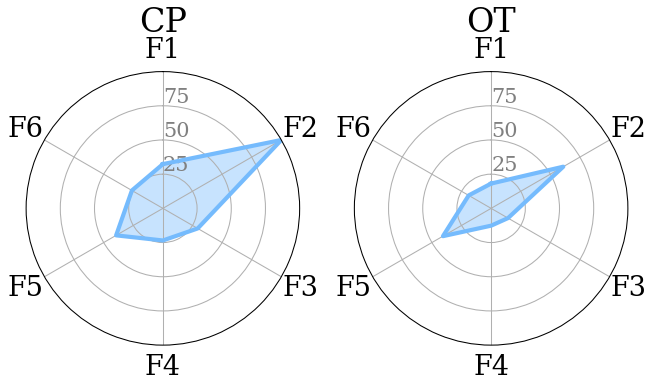

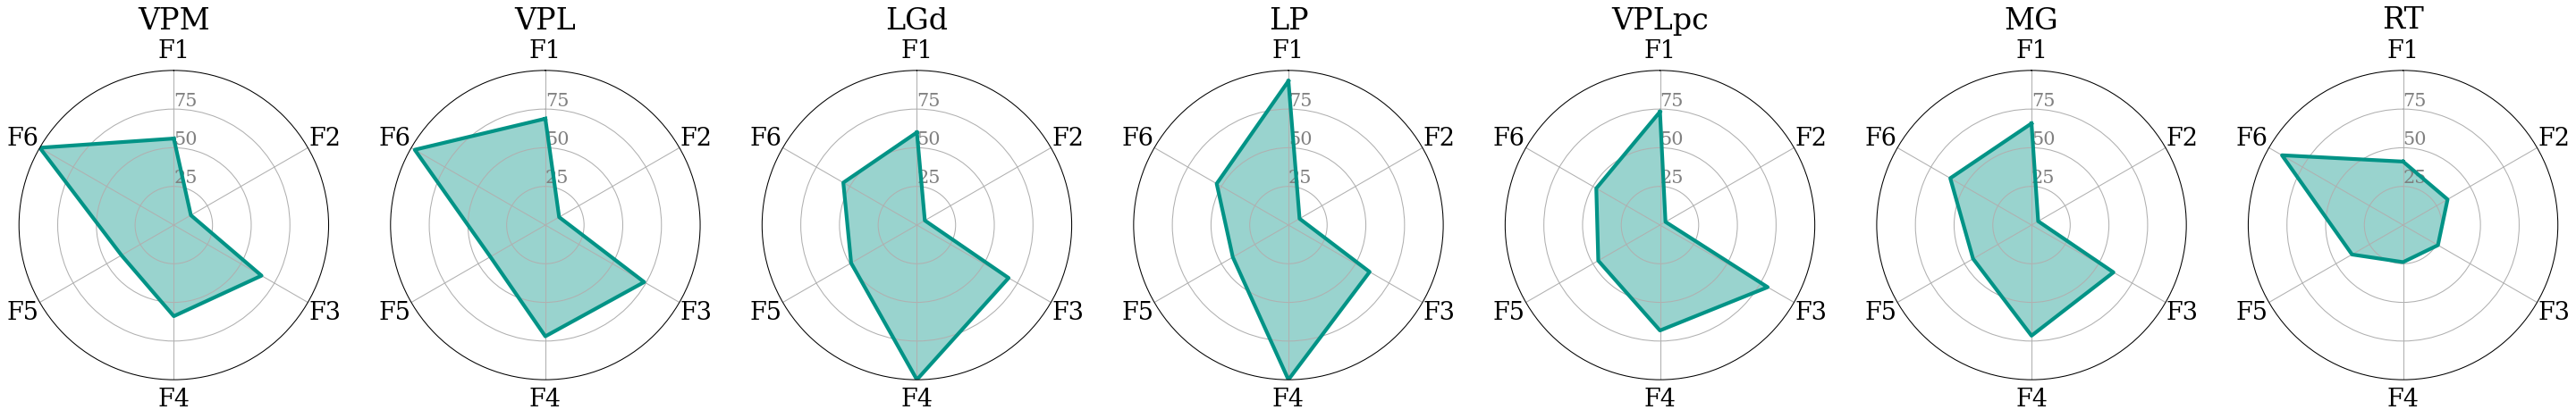

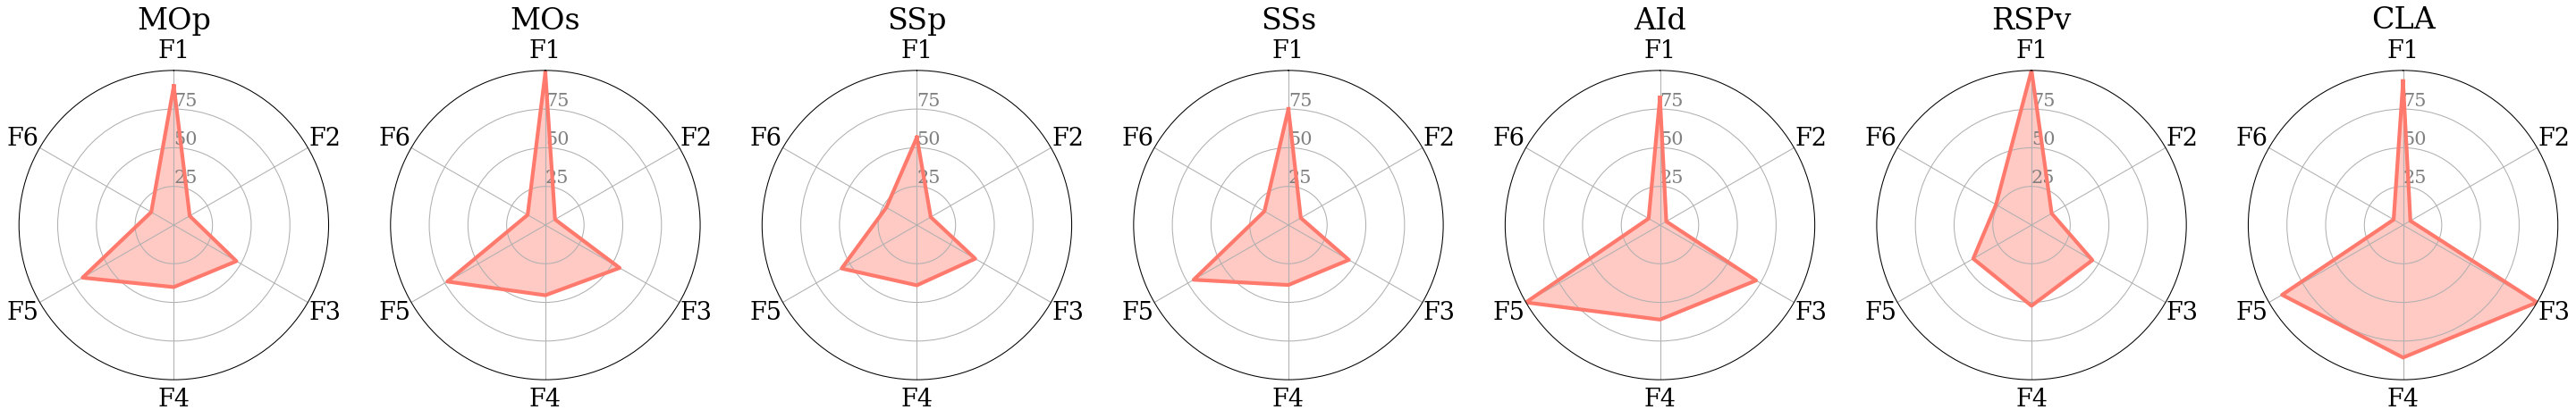

In [72]:
'''features: `radar_feas`'''
# raw_feas_file='ana_bouton_features.csv'
# all_feas=pd.read_csv(raw_feas_file,index_col=['name'])

# cell_simple_col=['name','projection_type','bnum','teb','br','bpath_den','bgeo_dist','targets']
radar_feas_labels=['# boutons','tebratio','d2s_mean','ed2s_mean','binterval_mean','neighborb_mean']
radar_feas=['F'+str(x+1) for x in np.arange(len(radar_feas_labels))]
radar_fea_array_all=np.zeros((len(ana_stypes),len(radar_feas)),)
for ity,ty in enumerate(ana_stypes):
    if ty == 'SSp':
        ty_df=all_feas[all_feas.soma_region.isin(ssp_regions)].copy()
    else:
        ty_df=all_feas[all_feas.soma_region==ty].copy()
    radar_fea_array_all[ity,0]=ty_df['bnum'].mean(0)
    radar_fea_array_all[ity,1]=ty_df['tebratio'].mean(0)
    radar_fea_array_all[ity,2]=ty_df['pd2s_mean'].mean(0)
    radar_fea_array_all[ity,3]=ty_df['ed2s_mean'].mean(0)
    radar_fea_array_all[ity,4]=ty_df['binterval_mean'].mean(0)
    radar_fea_array_all[ity,5]=ty_df['neighborb_mean'].mean(0)
def make_spider(df,row, title,color,type_num=6):
    # number of variable
    categories=list(df)[:-1]
    # print(categories)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,type_num+1,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=13)
    # ax.set_xticklabels(rotation=45)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=10)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('S-type').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=16, color='black', y=1.1)
for ti,ana_types in enumerate([cnu_stypes,th_stypes,ctx_stypes]):
    # ana_types=ctx_stypes
    radar_fea_array=np.zeros((len(ana_types),len(radar_feas)),)
    for ity,ty in enumerate(ana_types):
        if ty == 'SSp':
            ty_df=all_feas[all_feas.soma_region.isin(ssp_regions)].copy()
        else:
            ty_df=all_feas[all_feas.soma_region==ty].copy()
        radar_fea_array[ity,0]=ty_df['bnum'].mean(0)
        radar_fea_array[ity,1]=ty_df['tebratio'].mean(0)
        radar_fea_array[ity,2]=ty_df['pd2s_mean'].mean(0)
        radar_fea_array[ity,3]=ty_df['ed2s_mean'].mean(0)
        radar_fea_array[ity,4]=ty_df['binterval_mean'].mean(0)
        radar_fea_array[ity,5]=ty_df['neighborb_mean'].mean(0)
    #normalized to 0-100
    for i in range(len(radar_feas)):
        radar_fea_array[:,i]/=np.max(radar_fea_array_all[:,i])
    #
    radar_fea_df=pd.DataFrame(100*radar_fea_array,columns=radar_feas)
    radar_fea_df['S-type']=ana_types

    my_dpi=150
    rader_fig=plt.figure(figsize=(4*len(ana_types),4), dpi=my_dpi)
    
    # Loop to plot
    for row in range(0, len(radar_fea_df.index)):
        make_spider(radar_fea_df,row=row, title=radar_fea_df['S-type'][row],color=bcolors[ti],type_num=len(ana_types))

    rader_fig.savefig('./figs/'+str(btype[ti])+'_features.png',dpi=my_dpi)

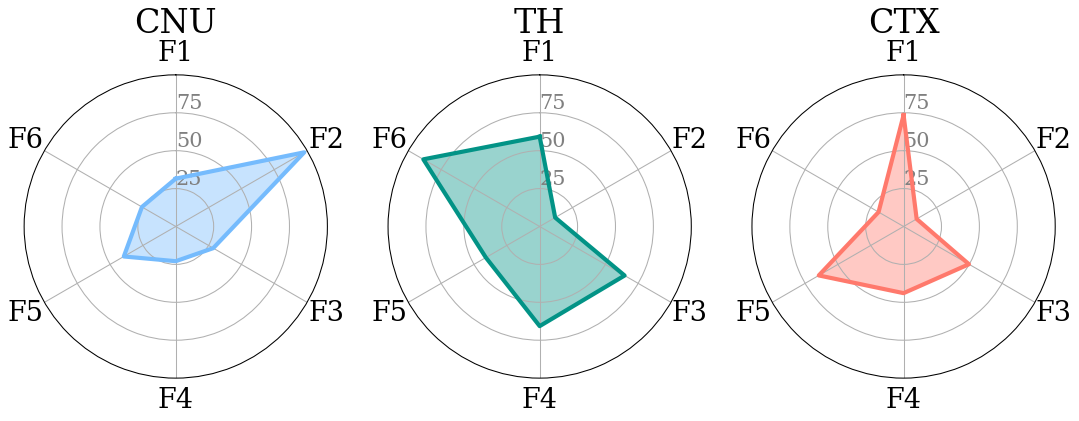

In [73]:
ana_types=[cnu_stypes,th_stypes,ctx_stypes]
radar_fea_array=np.zeros((len(ana_types),len(radar_feas)),)
for ity,ty in enumerate(ana_types):
    if ty.count('SSp'):
        ty_df=all_feas[(all_feas.soma_region.isin(ssp_regions))|
                       (all_feas.soma_region.isin(ty))].copy()
    else:
        ty_df=all_feas[all_feas.soma_region.isin(ty)].copy()
    radar_fea_array[ity,0]=ty_df['bnum'].mean(0)
    radar_fea_array[ity,1]=ty_df['tebratio'].mean(0)
    radar_fea_array[ity,2]=ty_df['pd2s_mean'].mean(0)
    radar_fea_array[ity,3]=ty_df['ed2s_mean'].mean(0)
    radar_fea_array[ity,4]=ty_df['binterval_mean'].mean(0)
    radar_fea_array[ity,5]=ty_df['neighborb_mean'].mean(0)
#normalized to 0-100
for i in range(len(radar_feas)):
    radar_fea_array[:,i]/=(np.max(radar_fea_array_all[:,i]))
#

radar_fea_df=pd.DataFrame(100*radar_fea_array,columns=radar_feas)
radar_fea_df['B-type']=btype
my_dpi=150
rader_fig=plt.figure(figsize=(4*len(ana_types),4), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(radar_fea_df.index))
def make_spider(df,row, title,color,type_num=6):
    # number of variable
    categories=list(df)[:-1]
    # print(categories)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,type_num+1,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=13)
    # ax.set_xticklabels(rotation=45)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=10)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('B-type').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=16, color='black', y=1.1)
# Loop to plot
for row in range(0, len(radar_fea_df.index)):
    make_spider(radar_fea_df,row=row, title=radar_fea_df['B-type'][row],color=bcolors[row],type_num=len(ana_types))

rader_fig.savefig('./figs/btype_cmp_features.png',dpi=my_dpi)

## bouton distribution along path

In [85]:
def bouton_dist2soma(inswc,d2s_bin_len=400,max_d2s_bins=40,
                        d2sfea='dist2soma'):
    maxdist=100000
    bdata=inswc[inswc.type>=5].copy()
    maxd2soma=bdata[d2sfea].max()
    sample_list=[]
    if maxd2soma:
        for bx in np.arange(1,max_d2s_bins+1):
            minbx=d2s_bin_len*(bx-1)
            maxbx=d2s_bin_len*bx
            if bx ==( max_d2s_bins +1):
                maxbx= maxdist
            sdf=bdata[(bdata[d2sfea]>minbx) & (bdata[d2sfea]<=maxbx)].copy()
            # print(sample_list)
            sample_list.append(sdf.shape[0])
    return sample_list

In [ ]:
# bouton distribution along path
d2s_bin_len=300
max_d2s_bins=40
bnum_d2s=pd.DataFrame()
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in bnum_d2s.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            bnums=bouton_dist2soma(inswc=swc,d2s_bin_len=d2s_bin_len,max_d2s_bins=max_d2s_bins)
            bnum_d2s[fname]=bnums
bnum_d2s=bnum_d2s.T
bnum_stype_d2s=pd.DataFrame()
for stype in ana_stypes:
    stype_clist=morpho_feas[morpho_feas.soma_region==stype].index
    if stype=='SSp':
        stype_clist=morpho_feas[morpho_feas.soma_region.isin(ssp_regions)].index
    stype_data=bnum_d2s.loc[bnum_d2s.index.isin(stype_clist),:]
    bnum_stype_d2s[stype]=stype_data.mean()
    bnum_stype_d2s[stype]/=bnum_stype_d2s[stype].sum()
bnum_stype_d2s=bnum_stype_d2s.T
bnum_stype_d2s.index.name='bin'
bnum_stype_d2s.to_csv('./bouton_dist2soma_stype.csv')

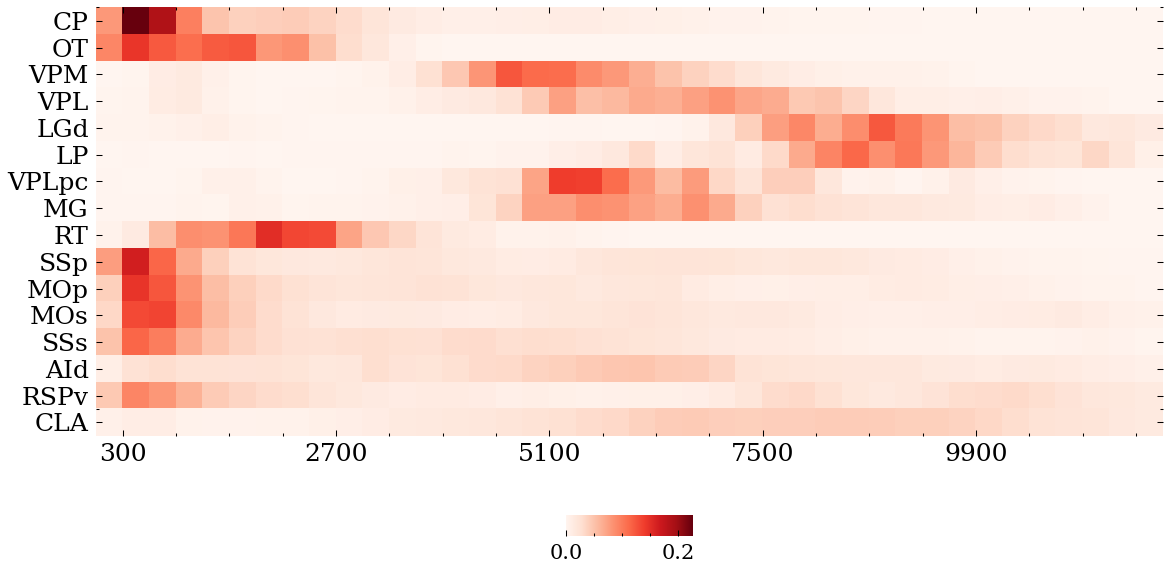

In [51]:
bnum_stype_d2s=pd.read_csv('./bouton_dist2soma_stype.csv',index_col=['bin'])
d2s_bin_len=300
max_d2s_bins=40
fig=plt.figure(figsize=(8,4),dpi=150)
plt.subplot(111)
ax=sns.heatmap(bnum_stype_d2s,cmap='Reds',
               yticklabels=False,
            #    xticklabels=False,
            #    square=True, 
               cbar_kws={
                'orientation':'horizontal',
                'fraction':0.04,
                'aspect':6,
                })
plt.xticks(ticks=np.arange(1,max_d2s_bins,8),fontsize=12,labels=[str(c*d2s_bin_len) for c in np.arange(1,max_d2s_bins,8)],rotation=0)
# plt.xticks(fontsize=12)
# plt.xticks(ticks=np.arange(1,showbin,8),fontsize=10,labels=[str(c*d2s_bin_len) for c in np.arange(1,showbin,8)],rotation=0)
plt.yticks(ticks=np.arange(bnum_stype_d2s.shape[0])+0.5,labels=bnum_stype_d2s.index.to_list(),fontsize=12)
ax.yaxis.set_minor_locator(MaxNLocator(1))
# ax.xaxis.set_major_locator(MaxNLocator(5))
plt.ylabel('')
plt.tight_layout()
plt.show()
fig.savefig('./figs/bouton_distribution_dist2soma.png',dpi=300)

In [110]:
# bouton spatial distribution
d2s_bin_len=100
max_d2s_bins=50
bnum_d2s=pd.DataFrame()
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in bnum_d2s.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            bnums=bouton_dist2soma(inswc=swc,d2s_bin_len=d2s_bin_len,
                                   max_d2s_bins=max_d2s_bins,
                                   d2sfea='edist2soma')
            bnum_d2s[fname]=bnums
bnum_d2s=bnum_d2s.T
bnum_stype_d2s=pd.DataFrame()
for stype in ana_stypes:
    stype_clist=morpho_feas[morpho_feas.soma_region==stype].index
    if stype=='SSp':
        stype_clist=morpho_feas[morpho_feas.soma_region.isin(ssp_regions)].index
    stype_data=bnum_d2s.loc[bnum_d2s.index.isin(stype_clist),:]
    bnum_stype_d2s[stype]=stype_data.mean()
    bnum_stype_d2s[stype]/=bnum_stype_d2s[stype].sum()
# bnum_stype_d2s=bnum_stype_d2s.T
bnum_stype_d2s.index.name='bin'
bnum_stype_d2s.to_csv('./bouton_edist2soma_stype.csv')

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



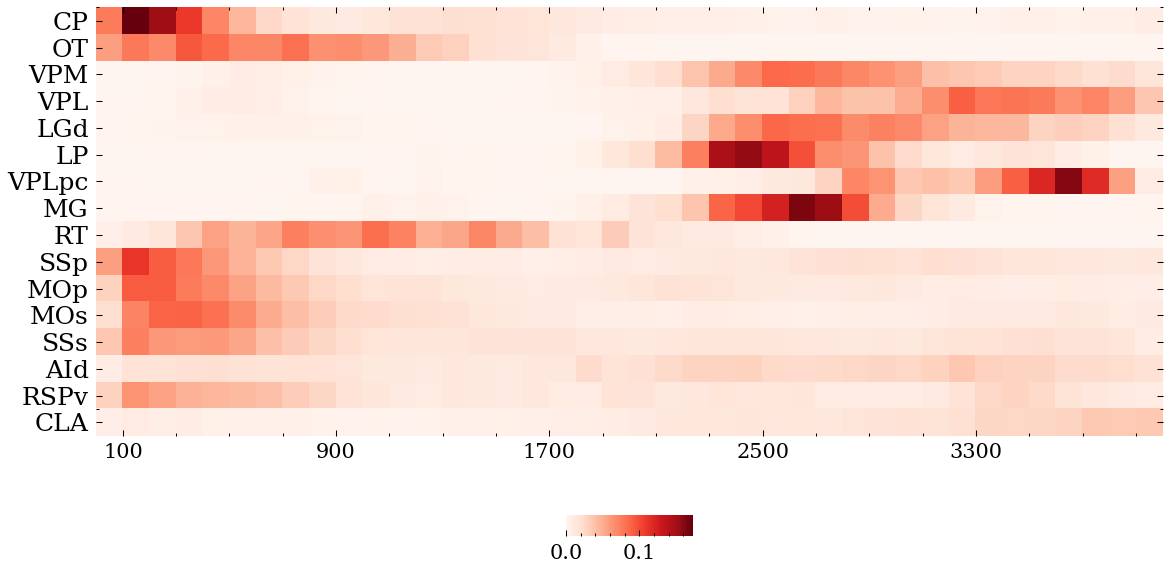

In [115]:
bnum_stype_d2s=pd.read_csv('./bouton_edist2soma_stype.csv',index_col=['bin'])
showbin=max_d2s_bins-10
fig=plt.figure(figsize=(8,4),dpi=150)
plt.subplot(111)
ax=sns.heatmap(bnum_stype_d2s.loc[bnum_stype_d2s.index<showbin,:].T,cmap='Reds',
               yticklabels=False,
            #    xticklabels=False,
            #    square=True, 
               cbar_kws={
                'orientation':'horizontal',
                'fraction':0.04,
                'aspect':6,
                })
plt.xticks(ticks=np.arange(1,showbin,8),fontsize=10,labels=[str(c*d2s_bin_len) for c in np.arange(1,showbin,8)],rotation=0)
plt.yticks(ticks=np.arange(bnum_stype_d2s.shape[1])+0.5,labels=bnum_stype_d2s.loc[bnum_stype_d2s.index<showbin,:].T.index.to_list(),fontsize=12)
# ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(MaxNLocator(1))
plt.tight_layout()
plt.show()
fig.savefig('./figs/bouton_distribution_edist2soma.png',dpi=300)

### inter-bouton distance 

In [ ]:
# get the correlation of pair IBD
# for each branch, from tail to head
# file_in='./ccf_bfea/17302_00007.eswc'
def bouton_cluster_analysis(file_in):
    swc=readswc(file=file_in,header=rheader,skiprows=1)
    ibdlists=[]
    for bid in swc[swc.type>=5].index:
        ibds=[]
        pibd=swc.loc[bid,'bdist']
        ibds.append(pibd)
        pid=swc.loc[bid,'parent']
        while True:
            if swc.loc[pid,'type']==1 or swc.loc[pid,'parent']<-1:
                break
            ppibd=swc.loc[pid,'bdist']
            if swc.loc[pid,'type']>=5:
                ibds.append(ppibd)
                break
            bid=pid
            pid=swc.loc[bid,'parent']
        if len(ibds) ==2:
            ibdlists.append(ibds)
    return ibdlists
bclusterdf=pd.DataFrame(columns=['dist2child','dist2parent','neuron','soma_region'])
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            dist_values=bouton_cluster_analysis(file_in=file_in)
            dist2nearb=pd.DataFrame(dist_values,columns=['dist2child','dist2parent'])
            dist2nearb['neuron']=fname
            dist2nearb['soma_region']=morpho_feas.loc[fname,'soma_region']
            bclusterdf=pd.concat([bclusterdf,dist2nearb],axis=0,ignore_index=True)
    bclusterdf.index.name='bpair'
bclusterdf.to_csv('./bouton_pair_dist.csv')

In [29]:
# multiple cores
ibddir='./pair_b_dist'
def bouton_cluster_analysis(name,para):
    file_in=para
    mfile=file_in.split('/')[-1]
    fname=mfile.split('.eswc')[0]
    topath=os.path.join(ibddir,fname+'.csv')
    if os.path.exists(topath):
        return {name:1}
    swc=readswc(file=file_in,header=rheader,skiprows=1)
    ibdlists=[]
    for bid in swc[swc.type>=5].index:
        ibds=[]
        pibd=swc.loc[bid,'bdist']
        ibds.append(pibd)
        pid=swc.loc[bid,'parent']
        while True:
            if swc.loc[pid,'type']==1 or swc.loc[pid,'parent']<-1:
                break
            ppibd=swc.loc[pid,'bdist']
            if swc.loc[pid,'type']>=5:
                ibds.append(ppibd)
                break
            bid=pid
            pid=swc.loc[bid,'parent']
        if len(ibds) ==2:
            ibdlists.append(ibds)
    # return ibdlists
    bclusterdf=pd.DataFrame(ibdlists,columns=['dist2child','dist2parent'])
    bclusterdf['name']=fname
    bclusterdf.index.name='bpair'
    bclusterdf.to_csv(topath)
    return {name:1}

para_dict={}
for root,dirs,files in os.walk(out_fea_path):
    for mfile in files:
        if mfile == '.DS_Store':
                continue
        file_in=os.path.join(root,mfile)
        
        fname=mfile.split('.eswc')[0]
        file_out=os.path.join(ibddir,fname+'.csv')
        if os.path.exists(file_out):
            continue
        para_dict[mfile]=file_in
        # outlist.append(file_out)
print(len(para_dict))

import multiprocessing as mp

num_cores = int(mp.cpu_count())
pool = mp.Pool(num_cores-2)
results = [pool.apply_async(bouton_cluster_analysis,args=(name,para)) for name,para in para_dict.items()]
results = [p.get() for p in results]
bclusterdf=pd.DataFrame(columns=['dist2child','dist2parent','name'])
if True:
    for root,dirs,files in os.walk(ibddir):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.csv')[0]
            # dist_values=bouton_cluster_analysis(file_in=file_in)
            dist2nearb=pd.read_csv(file_in,index_col=['bpair'])
            # dist2nearb['neuron']=fname
            # dist2nearb['soma_region']=morpho_feas.loc[fname,'soma_region']
            bclusterdf=pd.concat([bclusterdf,dist2nearb],axis=0,ignore_index=True)
            # break
    bclusterdf.index.name='bpair'
bclusterdf['soma_region']=[morpho_feas.loc[n,'soma_region'] for n in bclusterdf['name']]
bclusterdf.to_csv('./bouton_pair_dist.csv')

1891


In [38]:
bclusterdf[['dist2child','dist2parent']].corr()

,dist2child,dist2parent
dist2child,1.000000,0.132769
dist2parent,0.132769,1.000000


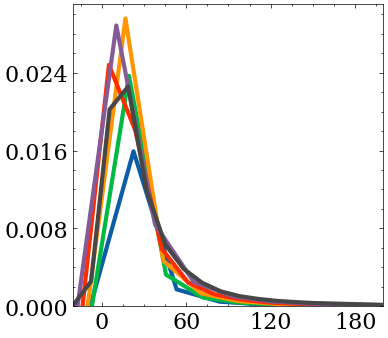

In [39]:
fig=plt.figure(figsize=(4,4),dpi=100)
fs=16
plt.subplot(111)
bpla=sns.color_palette(bcolors)
sdata=bclusterdf[bclusterdf.soma_region.isin(ana_regions)].copy()
dist_step_len=10
for dist_step in np.arange(6):
    showdata=sdata[(sdata.dist2child<=(dist_step_len*(dist_step+1)))&(sdata.dist2child>=dist_step*dist_step_len)].copy()
    ax=sns.kdeplot(data=showdata,x='dist2parent',
                   fill=False,linewidth=3)
ax.tick_params(axis='x',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.tick_params(axis='y',labelsize=fs)
ax.yaxis.set_major_locator(MaxNLocator(4))
# plt.legend(['CTX','TH','CNU'],title='',fontsize=fs,loc='upper left')
plt.xlabel('',fontsize=fs+2)
plt.ylabel('',fontsize=fs+2)
# plt.xlim([-500,1000])
plt.xlim([-20,200])
plt.show()
# fig.savefig('./figs/branch_seq_length_ratio.png',dpi=300)

In [ ]:
fig=plt.figure(figsize=(4,4),dpi=100)
fs=18
plt.subplot(111)
ax=sns.kdeplot(data=sdata,
             x='dist2child',
             y='dist2parent')
# sns.rugplot(x='axon_contraction',y='bouton_contraction',data=ana_data)
# ax.plot([0,1],[0,1],color='black',linestyle='--',linewidth=2,label='y=x')
ax.tick_params(axis='x',labelsize=fs)
ax.xaxis.set_minor_locator(MaxNLocator(1))
# ax.xaxis.set_major_locator(MaxNLocator(4))
ax.tick_params(axis='y',labelsize=fs)
# ax.yaxis.set_major_locator(MaxNLocator(4))
# ax.set_yscale('linear')
# plt.legend(fontsize=16)
# plt.legend(labels=['C'+str(c+1) for c in np.arange(n_clusters)],title='',fontsize=fs)
plt.xlabel('',fontsize=fs)
plt.ylabel('',fontsize=fs)
plt.xlim([0,100])
plt.ylim([0.,100])
plt.show()
# fig.savefig('./figs/bouton_uniform_distribute_ratio.png',dpi=300)

### bouton cluster analysis
based on minimum distance to near boutons (parent or child bouton)

In [40]:
'''dist2nb,neigborbs,interb_dist,uniform_bdist'''
def read_br_bd(file_in,min_bnum=5):
    brfea_raw=pd.read_csv(file_in)
    # axonal_brfea=brfea_raw[brfea_raw.type==2].copy()
    withb_brfea=brfea_raw[brfea_raw.bnum>=min_bnum].copy()
    mean_dist2nb=withb_brfea['dist2nb'].mean()
    mean_interb_dist=withb_brfea['interb_dist'].mean()
    mean_uniform_bdist=withb_brfea['uniform_bdist'].mean()
    median_dist2nb=withb_brfea['dist2nb'].median()
    median_interb_dist=withb_brfea['interb_dist'].median()
    median_uniform_bdist=withb_brfea['uniform_bdist'].median()
    return [mean_dist2nb,mean_interb_dist,mean_uniform_bdist,
            median_dist2nb,median_interb_dist,median_uniform_bdist]
brfea_dir='./brfeas'
brbrfeas_col_labels=['mean_dist2nb','mean_interb_dist','mean_uniform_bdist',
                     'median_dist2nb','median_interb_dist','median_uniform_bdist']
brbfeas=pd.DataFrame(columns=brbrfeas_col_labels)
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        # print(mfile)
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        brbfea=read_br_bd(file_in=file_in,min_bnum=4)
        fname=mfile.split('.eswc')[0]
        if fname in brbfeas.index:
            continue
        brbfeas.loc[fname,:]=brbfea
brbfeas.index.name='name'
brbfeas['soma_region']=morpho_feas['soma_region']
brbfeas.loc[:,'brain_region']= 'Other'
brbfeas.loc[brbfeas['soma_region'].isin(CNU),'brain_region']= 'CNU'
brbfeas.loc[brbfeas['soma_region'].isin(CTX),'brain_region']= 'CTX'
brbfeas.loc[brbfeas['soma_region'].isin(TH),'brain_region']= 'TH'
brbfeas.to_csv('./ana_branch_bouton_dist_features.csv',float_format='%.3f')

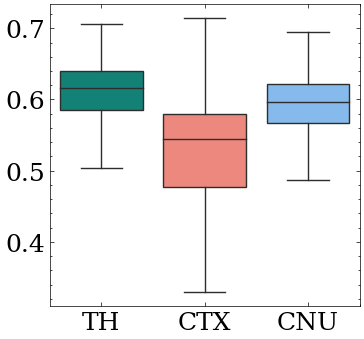

In [49]:
# difference of IBD and BPD
# ana_data=all_feas[['bdist2pb_mean','binterval_mean','soma_region','brain_region']].copy()
# brbfeas['buniform_ratio']=brbfeas['median_dist2nb']/brbfeas['median_uniform_bdist']
# brbfeas=pd.read_csv('./ana_branch_bouton_dist_features.csv',index_col=['name'])
brbfeas['buniform_ratio']=brbfeas['mean_dist2nb']/brbfeas['mean_uniform_bdist']

fig=plt.figure(figsize=(4,4),dpi=100)
fs=18
plt.subplot(111)
# btype=['CNU','TH','CTX']
# bcolors=['#029386','#ff796c','#75bbfd',]
ax=sns.boxplot(data=brbfeas[brbfeas.brain_region!='Other'],
             x='brain_region',
             y='buniform_ratio',
             showfliers=False,
             palette=sns.color_palette(['#029386','#ff796c','#75bbfd']))
# sns.rugplot(x='axon_contraction',y='bouton_contraction',data=ana_data)
# ax.plot([0,1],[0,1],color='black',linestyle='--',linewidth=2,label='y=x')
ax.tick_params(axis='x',labelsize=fs)
ax.xaxis.set_minor_locator(MaxNLocator(1))
# ax.xaxis.set_major_locator(MaxNLocator(4))
ax.tick_params(axis='y',labelsize=fs)
# ax.yaxis.set_major_locator(MaxNLocator(4))
# ax.set_yscale('linear')
# plt.legend(fontsize=16)
# plt.legend(labels=['C'+str(c+1) for c in np.arange(n_clusters)],title='',fontsize=fs)
plt.xlabel('',fontsize=fs)
plt.ylabel('',fontsize=fs)
# plt.xlim([0.75,1])
# plt.ylim([0.75,1])
plt.show()
fig.savefig('./figs/bouton_uniform_distribute_ratio.png',dpi=300)

In [ ]:
#inter-bouton distance along path
def IBD_dist2soma(inswc,d2s_bin_len=400,max_d2s_bins=40,
                        d2sfea='dist2soma'):
    ibd_fea='nearbdist'
    maxdist=100000
    bdata=inswc[inswc.type>=5].copy()
    maxd2soma=bdata[d2sfea].max()
    sample_list=[]
    if maxd2soma:
        for bx in np.arange(1,max_d2s_bins+1):
            minbx=d2s_bin_len*(bx-1)
            maxbx=d2s_bin_len*bx
            if bx ==( max_d2s_bins +1):
                maxbx= maxdist
            sdf=bdata[(bdata[d2sfea]>minbx) & (bdata[d2sfea]<=maxbx)].copy()
            # print(sample_list)
            if sdf.shape[0]:
                sample_list.append(sdf[ibd_fea].mean())
            else:
                sample_list.append(np.nan)
    return sample_list
d2s_bin_len=400
max_d2s_bins=40
bfea_values=pd.DataFrame()
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in bfea_values.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            bfea_value=IBD_dist2soma(inswc=swc,d2s_bin_len=d2s_bin_len,max_d2s_bins=max_d2s_bins)
            bfea_values[fname]=bfea_value
bfea_values=bfea_values.T
bfea_values_d2s=pd.DataFrame()
for stype in ana_stypes:
    stype_clist=morpho_feas[morpho_feas.soma_region==stype].index
    if stype=='SSp':
        stype_clist=morpho_feas[morpho_feas.soma_region.isin(ssp_regions)].index
    stype_data=bfea_values.loc[bfea_values.index.isin(stype_clist),:]
    bfea_values_d2s[stype]=stype_data.mean()
    # bfea_values_d2s[stype]/=bfea_values_d2s[stype].sum()
# bfea_values_d2s=bfea_values_d2s
fig=plt.figure(figsize=(5,6),dpi=150)
plt.subplot(111)
ax=sns.heatmap(bfea_values_d2s,cmap='Reds',
               yticklabels=False,
               vmax=50,
            #    xticklabels=False,
            #    square=True, 
               cbar_kws={
                'orientation':'vertical',
                'fraction':0.04,
                'aspect':8,
                })
plt.yticks(ticks=np.arange(1,max_d2s_bins,6),fontsize=10,labels=[str(c*d2s_bin_len) for c in np.arange(1,max_d2s_bins,6)])
plt.xticks(fontsize=12)
# ax.xaxis.set_major_locator(MaxNLocator(5))
plt.tight_layout()
plt.show()
# fig.savefig('./figs/bouton_distribution_dist2soma.png',dpi=300)

## bouton distribution in branch
1. split bouton branch into 3-10 parts
2. normalized bouton density barcode

In [125]:
allsdata_dir='./bouton_in_branch'
for split_num in np.arange(3,11):
    topath_f='./bouton_in_branch/bouton_branch_data_split_'+str(split_num)+'.csv'
    if os.path.exists(topath_f):
        continue
    sdata_dir=os.path.join(allsdata_dir,'S'+str(split_num))
    split_feas=['S'+str(x+1) for x in np.arange(split_num)]
    all_ana_data=pd.DataFrame()
    for root,dirs,files in os.walk(sdata_dir):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            indata=pd.read_csv(file_in)
            indata=indata[indata.total>=split_num].copy()
            for fea in split_feas:
                indata[fea]/=indata['total']
            indata['fname']=fname
            indata['stype']=morpho_feas.loc[fname,'soma_region']
            all_ana_data=pd.concat([all_ana_data,indata],axis=0,ignore_index=True)
            # break
    all_ana_data.index.name='brindex'
    all_ana_data.to_csv(topath_f)

In [1333]:
sdata_dir='./bouton_in_branch/S4'
split_num=4
topath_f='./all_bouton_branch_data_split_'+str(split_num)+'.csv'
split_feas=['S'+str(x+1) for x in np.arange(split_num)]
all_ana_data=pd.DataFrame()
if True:
    for root,dirs,files in os.walk(sdata_dir):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            indata=pd.read_csv(file_in)
            indata=indata[indata.total>=split_num].copy()
            for fea in split_feas:
                indata[fea]/=indata['total']
            indata['fname']=fname
            indata['stype']=morpho_feas.loc[fname,'soma_region']
            all_ana_data=pd.concat([all_ana_data,indata],axis=0,ignore_index=True)

all_ana_data.index.name='brindex'
all_ana_data.to_csv(topath_f)

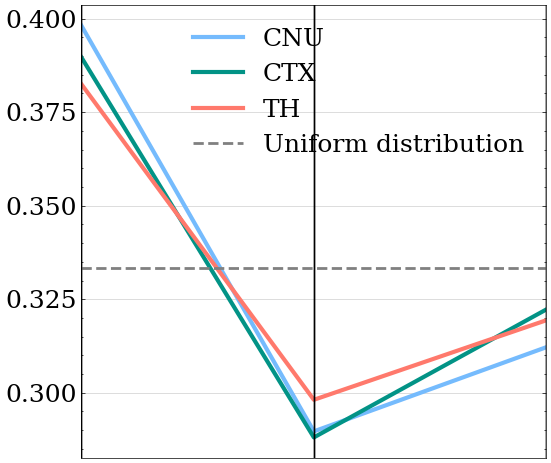

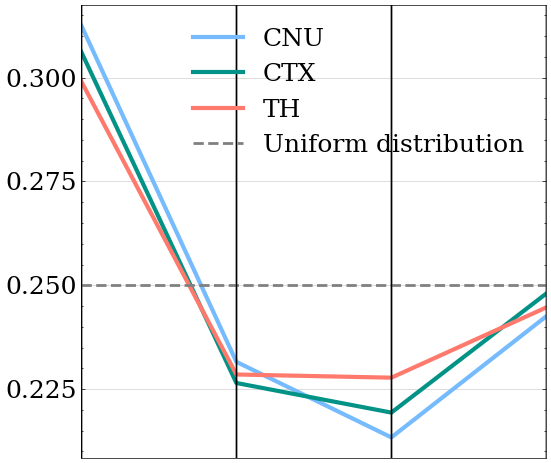

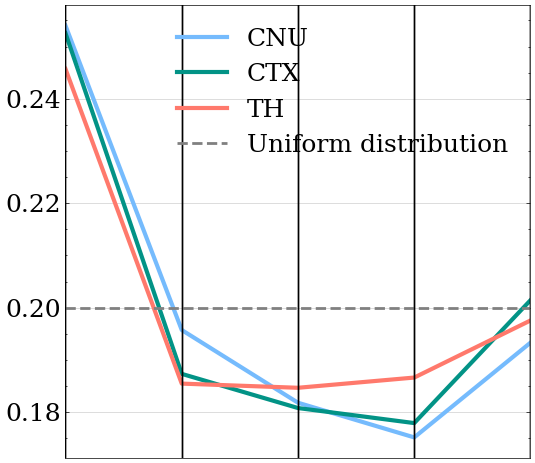

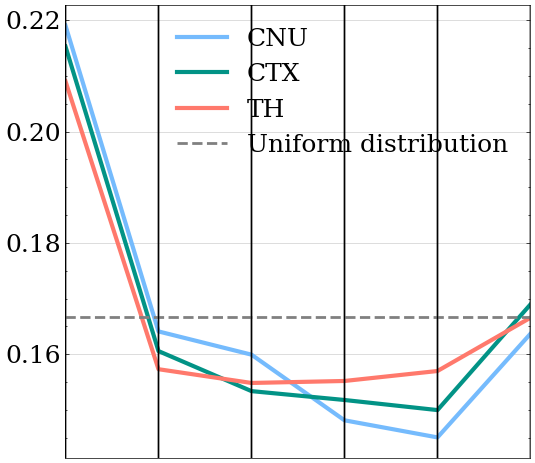

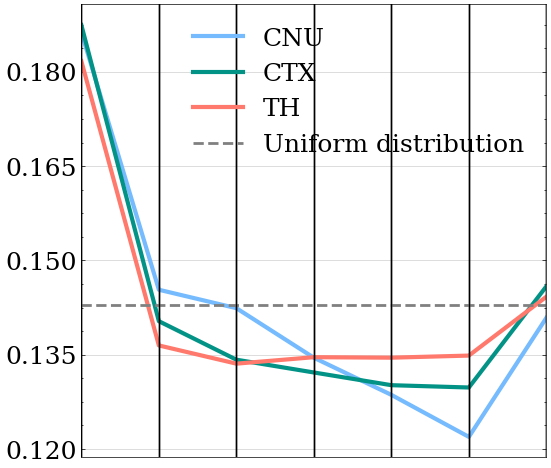

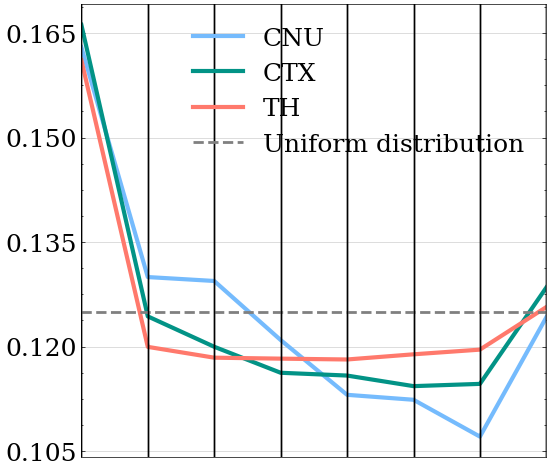

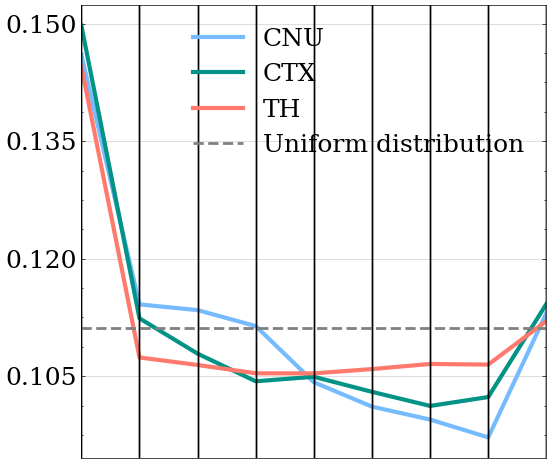

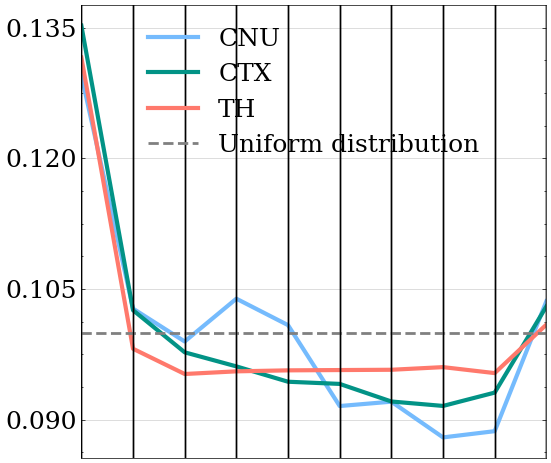

In [9]:
for split_num in np.arange(3,11):
    topath_f='./bouton_in_branch/bouton_branch_data_split_'+str(split_num)+'.csv'
    if not os.path.exists(topath_f):
        continue
    split_feas=['S'+str(x+1) for x in np.arange(split_num)]
    all_ana_data=pd.read_csv(topath_f,index_col=['brindex'])
    ana_stypes_dis=pd.DataFrame(columns=split_feas)
    for stype in ana_stypes:
        ana_stype_df=all_ana_data[all_ana_data.stype==stype].copy()
        if stype=='SSp':
            ana_stype_df=all_ana_data[all_ana_data.stype.isin(ssp_regions)]
        ana_stypes_dis.loc[stype,:]=ana_stype_df[split_feas].mean()
    ana_stypes_dis.loc[ana_stypes_dis.index.isin(cnu_stypes),'brain_region']='CNU'
    ana_stypes_dis.loc[ana_stypes_dis.index.isin(ctx_stypes),'brain_region']='CTX'
    ana_stypes_dis.loc[ana_stypes_dis.index.isin(th_stypes),'brain_region']='TH'
    ana_stypes_dis_show=ana_stypes_dis.groupby(['brain_region']).mean().copy()
    ana_stypes_dis_show.reset_index(inplace=True)
    ana_stypes_dis_avg=pd.DataFrame(columns=split_feas)
    ana_stypes_dis_avg.loc['avg_ratio',split_feas]=1/split_num
    ana_stypes_dis_avg.loc['avg_ratio','type']='Uniform distribution'
    # Plot
    fig=plt.figure(figsize=(6,6),dpi=100)
    ax=plt.subplot(111)
    parallel_coordinates(ana_stypes_dis_show, 'brain_region', color=bcolors,linewidth=3)
    parallel_coordinates(ana_stypes_dis_avg, 'type', color='grey',linewidth=2,linestyle='--')
    # ax.plot(x=1+np.arange(len(split_feas)),y=np.ones(len(split_feas))*0.25)
    ax.tick_params(axis='x',labelsize=18)
    ax.tick_params(axis='y',labelsize=18)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    # Lighten borders
    # plt.gca().spines["top"].set_alpha(0)
    # plt.gca().spines["bottom"].set_alpha(.3)
    # plt.gca().spines["right"].set_alpha(0)
    # plt.gca().spines["left"].set_alpha(.3)
    plt.xticks([])
    plt.legend(fontsize=18)
    # plt.title('Parallel Coordinated of Diamonds', fontsize=22)
    plt.grid(alpha=0.6)
    plt.show() 
    fig.savefig('./figs/bouton_distribution_in_branch'+str(split_num)+'.png',dpi=300)

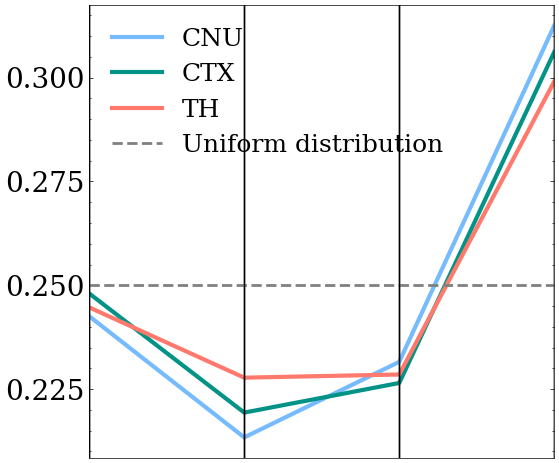

In [126]:
split_num=4
topath_f='./bouton_in_branch/bouton_branch_data_split_'+str(split_num)+'.csv'
if os.path.exists(topath_f):
    split_feas=['S'+str(split_num-x) for x in np.arange(split_num)]
    all_ana_data=pd.read_csv(topath_f,index_col=['brindex'])
    ana_stypes_dis=pd.DataFrame(columns=split_feas)
    for stype in ana_stypes:
        ana_stype_df=all_ana_data[all_ana_data.stype==stype].copy()
        if stype=='SSp':
            ana_stype_df=all_ana_data[all_ana_data.stype.isin(ssp_regions)]
        ana_stypes_dis.loc[stype,:]=ana_stype_df[split_feas].mean()
ana_stypes_dis.loc[ana_stypes_dis.index.isin(cnu_stypes),'brain_region']='CNU'
ana_stypes_dis.loc[ana_stypes_dis.index.isin(ctx_stypes),'brain_region']='CTX'
ana_stypes_dis.loc[ana_stypes_dis.index.isin(th_stypes),'brain_region']='TH'
ana_stypes_dis_show=ana_stypes_dis.groupby(['brain_region']).mean().copy()
ana_stypes_dis_show.reset_index(inplace=True)
# ana_stypes_dis_avg=
ana_stypes_dis_avg=pd.DataFrame(columns=split_feas)
ana_stypes_dis_avg.loc['avg_ratio',split_feas]=1/split_num
ana_stypes_dis_avg.loc['avg_ratio','type']='Uniform distribution'
# Plot
fig=plt.figure(figsize=(6,6),dpi=100)
ax=plt.subplot(111)
parallel_coordinates(ana_stypes_dis_show, 'brain_region', color=bcolors,linewidth=3)
parallel_coordinates(ana_stypes_dis_avg, 'type', color='grey',linewidth=2,linestyle='--')
# ax.plot(x=1+np.arange(len(split_feas)),y=np.ones(len(split_feas))*0.25)
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=20)
ax.yaxis.set_major_locator(MaxNLocator(5))
# Lighten borders
# plt.gca().spines["top"].set_alpha(0)
# plt.gca().spines["bottom"].set_alpha(.3)
# plt.gca().spines["right"].set_alpha(0)
# plt.gca().spines["left"].set_alpha(.3)
plt.xticks([])
plt.legend(fontsize=18)
# plt.title('Parallel Coordinated of Diamonds', fontsize=22)
# plt.grid(alpha=0.6)
# ax.set_axis_off()
plt.show()  
fig.savefig('./figs/bouton_distribution_in_branch.png',dpi=300)

## local-distal bouton ratio
1. path distance to soma
2. euclidean distance to soma

In [79]:
def bouton_dis_ratio(inswc,d2sfea='dist2soma',split_num=2):
    max_d2s=inswc[d2sfea].max()
    swc=inswc[inswc.type>=5].copy()
    dis_ratio=np.zeros(split_num)
    for b in np.arange(split_num):
        l=b*max_d2s/split_num
        r=(b+1)*max_d2s/split_num
        dratio=swc[(swc[d2sfea]>l)&(swc[d2sfea]<=r)].shape[0]/swc.shape[0]
        dis_ratio[b]=dratio
    return dis_ratio

In [80]:
'''path distance to soma: split into 4 parts'''
bouton_ld_df_f='./bouton_local_distal_ratio.csv'
split_num=4
bouton_ld_df=pd.DataFrame(columns=['P'+str(p+1) for p in np.arange(split_num)])
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in bouton_ld_df.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            if swc[swc.type>=5].shape[0]==0:
                continue
            bouton_ld_df.loc[fname,:]=bouton_dis_ratio(inswc=swc,split_num=split_num)

bouton_ld_df.index.name='name'
bouton_ld_df['soma_region']=morpho_feas['soma_region']
bouton_ld_df.loc[:,'brain_region']= 'Other'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CNU),'brain_region']= 'CNU'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CTX),'brain_region']= 'CTX'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(TH),'brain_region']= 'TH'
bouton_ld_df.to_csv(bouton_ld_df_f)

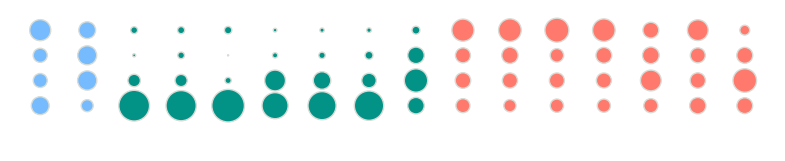

In [81]:
# bouton_ld_df_f='./bouton_local_distal_ratio.csv'
# bouton_ld_df=pd.read_csv(bouton_ld_df_f,index_col=['name'])
bouton_ld_df.loc[:,'brain_region']= 'Other'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CNU),'brain_region']= 'CNU'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CTX),'brain_region']= 'CTX'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(TH),'brain_region']= 'TH'
fig=plt.figure(figsize=(10,2),dpi=100)
ax=plt.subplot(111)
yd=split_num-np.arange(split_num)
m_max_size=600
for ai,astype in enumerate(ana_stypes):
    scolor=bcolors[2]
    if astype in cnu_stypes:
        scolor=bcolors[0]
    elif astype in th_stypes:
        scolor=bcolors[1]
    if astype == 'SSp':
        ana_data=bouton_ld_df[bouton_ld_df.soma_region.isin(ssp_regions)].copy()
    else:
        ana_data=bouton_ld_df[bouton_ld_df.soma_region==astype].copy()
    ana_data_mean=ana_data[['P'+str(p+1) for p in np.arange(split_num)]].mean().values
    ax.scatter(x=ai*np.ones(split_num),y=yd,s=ana_data_mean*m_max_size,c=scolor,alpha=1,marker='o',edgecolors='#d8dcd6')
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
# ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_yticks(np.arange(split_num))
# ax.set_yticklabels([str((c+1)*0.25) for c in np.arange(split_num)])
plt.ylim([-1,5])
ax.set_axis_off()
# ax.set_xticks(np.arange(len(ana_stypes)))
# ax.set_xticklabels(ana_stypes)
# plt.ylim([-2,4])
# plt.grid(axis='y',linestyle=':',linewidth=1)
plt.show()
fig.savefig('./figs/bouton_local_distal_ratio.png',dpi=300)

In [82]:
'''Euclidean distance to soma: split into 4 parts'''
bouton_ld_edf_f='./bouton_local_distal_eulidean_ratio.csv'
split_num=4
bouton_ld_df=pd.DataFrame(columns=['P'+str(p+1) for p in np.arange(split_num)])
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in bouton_ld_df.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            if swc[swc.type>=5].shape[0]==0:
                continue
            bouton_ld_df.loc[fname,:]=bouton_dis_ratio(inswc=swc,split_num=split_num,d2sfea='edist2soma')

bouton_ld_df.index.name='name'
bouton_ld_df['soma_region']=morpho_feas['soma_region']
bouton_ld_df.loc[:,'brain_region']= 'Other'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CNU),'brain_region']= 'CNU'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CTX),'brain_region']= 'CTX'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(TH),'brain_region']= 'TH'
bouton_ld_df.to_csv(bouton_ld_edf_f)

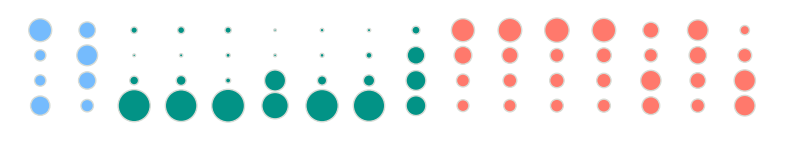

In [83]:
# bouton_ld_edf_f='./bouton_local_distal_eulidean_ratio.csv'
# bouton_ld_df=pd.read_csv(bouton_ld_edf_f,index_col=['name'])
bouton_ld_df.loc[:,'brain_region']= 'Other'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CNU),'brain_region']= 'CNU'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(CTX),'brain_region']= 'CTX'
bouton_ld_df.loc[bouton_ld_df['soma_region'].isin(TH),'brain_region']= 'TH'
fig=plt.figure(figsize=(10,2),dpi=100)
ax=plt.subplot(111)
yd=split_num-np.arange(split_num)
m_max_size=600
for ai,astype in enumerate(ana_stypes):
    scolor=bcolors[2]
    if astype in cnu_stypes:
        scolor=bcolors[0]
    elif astype in th_stypes:
        scolor=bcolors[1]
    if astype == 'SSp':
        ana_data=bouton_ld_df[bouton_ld_df.soma_region.isin(ssp_regions)].copy()
    else:
        ana_data=bouton_ld_df[bouton_ld_df.soma_region==astype].copy()
    ana_data_mean=ana_data[['P'+str(p+1) for p in np.arange(split_num)]].mean().values
    ax.scatter(x=ai*np.ones(split_num),y=yd,s=ana_data_mean*m_max_size,c=scolor,alpha=1,marker='o',edgecolors='#d8dcd6')
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
# ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_yticks(np.arange(split_num))
# ax.set_yticklabels([str((c+1)*0.25) for c in np.arange(split_num)])
plt.ylim([-1,5])
ax.set_axis_off()
# ax.set_xticks(np.arange(len(ana_stypes)))
# ax.set_xticklabels(ana_stypes)
# plt.ylim([-2,4])
# plt.grid(axis='y',linestyle=':',linewidth=1)
plt.show()
fig.savefig('./figs/bouton_local_distal_euclidean_ratio.png',dpi=300)

## node level contraction
是否bouton所在的局部形态的contraction更小，也就是更弯曲一点

In [128]:
bouton_f='./all_bouton_data.csv'
all_boutons=pd.DataFrame()
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in all_boutons.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            ana_swc=swc[(swc.type==5)|(swc.type==6)].copy()
            ana_swc.drop(['parent'],axis=1,inplace=True)
            ana_swc['fname']=fname
            ana_swc['stype']=morpho_feas.loc[fname,'soma_region']
            all_boutons=pd.concat([all_boutons,ana_swc],axis=0,ignore_index=True)

all_boutons.index.name='bindex'
all_boutons.to_csv(bouton_f)

In [133]:
all_boutons.shape

(2578183, 13)

In [129]:
ana_data_f='./node_contraction_feas.csv'
ana_data=pd.DataFrame()
if True:
    for root,dirs,files in os.walk(out_fea_path):
        for mfile in files:
            if mfile == '.DS_Store':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.eswc')[0]
            if fname in all_boutons.index:
                continue
            swc=readswc(file=file_in,header=rheader,skiprows=1)
            ana_swc=swc.loc[((swc.type==2)|(swc.type>=5))&(swc.node_contraction>0),:].copy()
            ana_data.loc[fname,'axon_contraction']=ana_swc.loc[ana_swc.type==2,'node_contraction'].mean()
            ana_data.loc[fname,'bouton_contraction']=ana_swc.loc[ana_swc.type>=5,'node_contraction'].mean()
            ana_data.loc[fname,'soma_region']=morpho_feas.loc[fname,'soma_region']
ana_data.index.name='name'
ana_data.to_csv(ana_data_f)

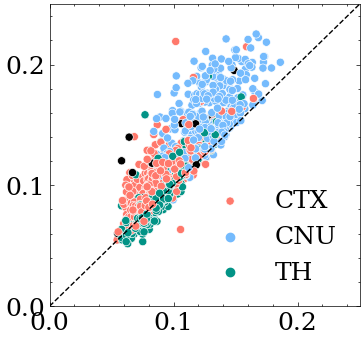

In [132]:
# ana_data_f='./node_contraction_feas.csv'
# ana_data=pd.read_csv(ana_data_f,index_col=['name'])
ana_data.loc[:,'brain_region']= 'Other'
ana_data.loc[ana_data['soma_region'].isin(CNU),'brain_region']= 'CNU'
ana_data.loc[ana_data['soma_region'].isin(CTX),'brain_region']= 'CTX'
ana_data.loc[ana_data['soma_region'].isin(TH),'brain_region']= 'TH'
fig=plt.figure(figsize=(4,4),dpi=100)
fs=18
plt.subplot(111)
ana_data['axon_contraction']=1-ana_data['axon_contraction']
ana_data['bouton_contraction']=1-ana_data['bouton_contraction']
ax=sns.scatterplot(data=ana_data,
             x='axon_contraction',y='bouton_contraction',
             hue='brain_region',hue_order=btype,
             s=35,palette=sns.color_palette(bcolors),alpha=1)
# sns.rugplot(x='axon_contraction',y='bouton_contraction',data=ana_data)
plt.legend(labels=['CTX','CNU','TH'],title='',fontsize=fs)
ax.plot([0,1],[0,1],color='black',linestyle='--',linewidth=1)
ax.tick_params(axis='x',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(3))
ax.tick_params(axis='y',labelsize=fs)
ax.yaxis.set_major_locator(MaxNLocator(3))
# ax.set_yscale('linear')
# plt.legend(fontsize=16)

plt.xlabel('',fontsize=fs)
plt.ylabel('',fontsize=fs)
plt.xlim([0,0.25])
plt.ylim([0,0.25])
plt.show()
fig.savefig('./figs/bouton_site_contraction_cmp.png',dpi=300)

## bouton in branch sequence
split the path from soma to tip into two parts: 
1. without bouton sequence
2. with bouton sequence

For w_bouton_seq, get bouton distribution at branch level

In [84]:
# multiple cores: convert branch data to branch sequences
brseqsdata='./brseqs'
def br_seq_data(name,para):
    file_in=para
    mfile=file_in.split('/')[-1]
    fname=mfile.split('.eswc')[0]
    topath=os.path.join(brseqsdata,fname+'.csv')
    if os.path.exists(topath):
        return {name:1}
    brfea_raw=pd.read_csv(file_in,index_col=['id'])
    # get tip-brs
    tips=[]
    for br in brfea_raw.index:
        if br in brfea_raw['parent_id'].to_list():
            continue
        tips.append(br)
    #label bouton-seq and no-bouton-seq
    bouton_seq=pd.DataFrame(index=np.arange(1,1+brfea_raw['level'].max()))
    br_i=0
    for br in tips:
        bseq=[]
        bseq.append(brfea_raw.loc[br,'bnum'])
        pbr=brfea_raw.loc[br,'parent_id']
        while pbr in brfea_raw.index:
            bseq.append(brfea_raw.loc[pbr,'bnum'])
            br=pbr
            pbr=brfea_raw.loc[br,'parent_id']
        if np.sum(bseq) <=0:
            continue
        while len(bseq) != bouton_seq.shape[0]:
            bseq.append(-1)
        br_i+=1
        bseqdf=pd.Series(bseq,name=br_i)
        bouton_seq=pd.concat([bouton_seq,bseqdf],axis=1)
    bouton_seq.to_csv(topath)
    return {name:1}

para_dict={}
brfea_dir='./brfeas'
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        if mfile == '.DS_Store':
                continue
        file_in=os.path.join(root,mfile)
        fname=mfile.split('.eswc')[0]
        file_out=os.path.join(brseqsdata,fname+'.csv')
        if os.path.exists(file_out):
            continue
        para_dict[mfile]=file_in
        # outlist.append(file_out)
print(len(para_dict))
num_cores = int(mp.cpu_count())
pool = mp.Pool(num_cores-2)
results = [pool.apply_async(br_seq_data,args=(name,para)) for name,para in para_dict.items()]
results = [p.get() for p in results]

1891


1891


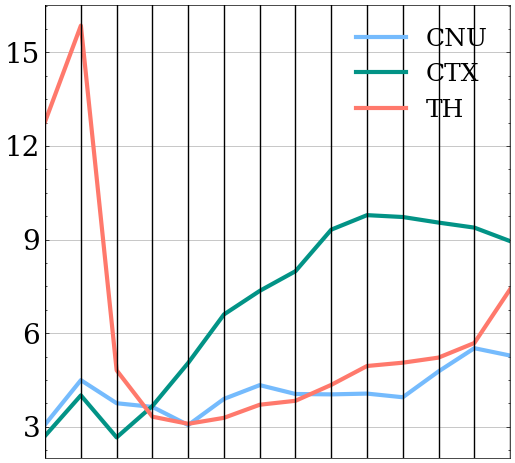

In [23]:
# multiple cores: extract w_branch sequences
wbrseqsdata='./wbrseq'
brseqsdata='./brseqs'
split_num=14
split_path=os.path.join(wbrseqsdata,'S'+str(split_num))
if not os.path.exists(split_path):
    os.mkdir(split_path)

def wbr_seq_data(name,para):
    file_in=para
    mfile=file_in.split('/')[-1]
    fname=mfile.split('.eswc')[0]
    topath=os.path.join(split_path,fname+'.csv')
    if os.path.exists(topath):
        return {name:1}
    bouton_seq=pd.read_csv(file_in,index_col=0)
    #get wb_seq
    wb_seqs=[]
    for seq in bouton_seq.keys():
        wbseq=[]
        for br in bouton_seq.index:
            if bouton_seq.loc[bouton_seq.index>=br,seq].max() > 0:
                wbseq.append(bouton_seq.loc[br,seq])
            else:
                break
        if len(wbseq)==split_num:
            wb_seqs.append(wbseq)
    wb_seq_brs_list=[]
    for wbseq in wb_seqs:
        wb_seq_brs=np.zeros(split_num)
        seq_len=len(wbseq)
        step_len=int(seq_len/split_num)
        for i in np.arange(split_num):
            l=i*step_len
            r=(i+1)*step_len+1
            if r>seq_len:
                r=seq_len
            wb_seq_brs[i]=np.sum(wbseq[l:r])
        wb_seq_brs_list.append(wb_seq_brs)
    if len(wb_seq_brs_list):
        outdf=pd.DataFrame(wb_seq_brs_list,columns=['S'+str(i) for i in np.arange(split_num)])
        outdf.to_csv(topath)
    return {name:1}

para_dict={}

for root,dirs,files in os.walk(brseqsdata):
    for mfile in files:
        if mfile == '.DS_Store':
                continue
        file_in=os.path.join(root,mfile)
        fname=mfile.split('.eswc')[0]
        file_out=os.path.join(split_path,fname+'.csv')
        if os.path.exists(file_out):
            continue
        para_dict[mfile]=file_in
        # break
        # outlist.append(file_out)
print(len(para_dict))

num_cores = int(mp.cpu_count())
pool = mp.Pool(num_cores-2)
results = [pool.apply_async(wbr_seq_data,args=(name,para)) for name,para in para_dict.items()]
results = [p.get() for p in results]

if True:    
    toseqpath='./wbrseq/br_seq_nor_feas_s'+str(split_num)+'.csv'
    columns=['S'+str(i) for i in np.arange(split_num)]
    columns+=['name','soma_region']
    wbseq_dis=pd.DataFrame(columns=columns)
    for root,dirs,files in os.walk(split_path):
        for mfile in files:
            # print(mfile)
            if os.path.splitext(mfile)[1] != '.csv':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.csv')[0]
            wbr_dis_df=pd.read_csv(file_in,index_col=0)
            wbr_dis_df['name']=fname
            wbr_dis_df['soma_region']=morpho_feas.loc[fname,'soma_region']
            wbseq_dis=pd.concat([wbseq_dis,wbr_dis_df],axis=0,ignore_index=True)
    wbseq_dis.index.name='wbseq'
    wbseq_dis.to_csv(toseqpath,float_format='%.3f')
    split_feas=['S'+str(split_num-x-1) for x in np.arange(split_num)]
    all_ana_data=wbseq_dis.copy()
    ana_stypes_dis=pd.DataFrame(columns=split_feas)
    for stype in ana_stypes:
        ana_stype_df=all_ana_data[all_ana_data.soma_region==stype].copy()
        if stype=='SSp':
            ana_stype_df=all_ana_data[all_ana_data.soma_region.isin(ssp_regions)]
        ana_stypes_dis.loc[stype,:]=ana_stype_df[split_feas].mean()
ana_stypes_dis.loc[ana_stypes_dis.index.isin(cnu_stypes),'brain_region']='CNU'
ana_stypes_dis.loc[ana_stypes_dis.index.isin(ctx_stypes),'brain_region']='CTX'
ana_stypes_dis.loc[ana_stypes_dis.index.isin(th_stypes),'brain_region']='TH'
ana_stypes_dis_show=ana_stypes_dis.groupby(['brain_region']).mean().copy()
ana_stypes_dis_show.reset_index(inplace=True)
# ana_stypes_dis_avg=
ana_stypes_dis_avg=pd.DataFrame(columns=split_feas)
fig=plt.figure(figsize=(6,6),dpi=100)
ax=plt.subplot(111)
parallel_coordinates(ana_stypes_dis_show, 'brain_region', color=bcolors,linewidth=3)
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=20)
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.xticks([])
plt.legend(fontsize=18)
plt.show()  
fig.savefig('./figs/bouton_distribution_in_branch_seq_s'+str(split_num)+'.png',dpi=300)

<AxesSubplot:>

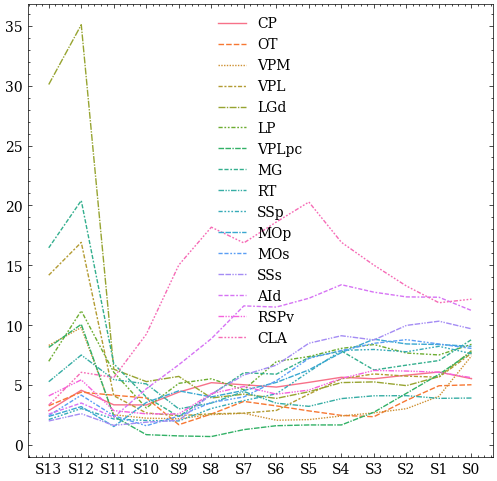

In [36]:
# ana_stypes=ana_stypes_dis.index.to_list()
ana_data=ana_stypes_dis.drop(['brain_region'],axis=1).T.copy()
fig=plt.figure(figsize=(6,6),dpi=100)
ax=plt.subplot(111)
sns.lineplot(ana_data)

In [ ]:
def read_wbr_seq(file_in,split_num=3):
    bouton_seq=pd.read_csv(file_in,index_col=0)
    #get wb_seq
    wb_seqs=[]
    for seq in bouton_seq.keys():
        wbseq=[]
        for br in bouton_seq.index:
            if bouton_seq.loc[bouton_seq.index>=br,seq].max() > 0:
                wbseq.append(bouton_seq.loc[br,seq])
            else:
                break
        if len(wbseq)==split_num:
            wb_seqs.append(wbseq)
    wb_seq_brs_list=[]
    for wbseq in wb_seqs:
        wb_seq_brs=np.zeros(split_num)
        seq_len=len(wbseq)
        step_len=int(seq_len/split_num)
        for i in np.arange(split_num):
            l=i*step_len
            r=(i+1)*step_len+1
            if r>seq_len:
                r=seq_len
            wb_seq_brs[i]=np.sum(wbseq[l:r])
        wb_seq_brs_list.append(wb_seq_brs)
    outdf=pd.DataFrame(wb_seq_brs_list,columns=['S'+str(i) for i in np.arange(split_num)])
    return outdf
for s in np.arange(10,11):
    split_num=s
    toseqpath='./wbrseq_distribution/br_seq_nor_feas_s'+str(split_num)+'.csv'
    if os.path.exists(toseqpath):
        continue
    columns=['S'+str(i) for i in np.arange(split_num)]
    columns+=['name','soma_region']
    wbseq_dis=pd.DataFrame(columns=columns)
    for root,dirs,files in os.walk(brseqsdata):
        for mfile in files:
            # print(mfile)
            if os.path.splitext(mfile)[1] != '.csv':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.csv')[0]
            wbr_dis_df=read_wbr_seq(file_in=file_in,split_num=split_num)
            wbr_dis_df['name']=fname
            wbr_dis_df['soma_region']=morpho_feas.loc[fname,'soma_region']
            wbseq_dis=pd.concat([wbseq_dis,wbr_dis_df],axis=0,ignore_index=True)
    wbseq_dis.index.name='wbseq'
    # wbseq_dis.loc[:,'brain_region']= 'Other'
    # wbseq_dis.loc[wbseq_dis['soma_region'].isin(CNU),'brain_region']= 'CNU'
    # wbseq_dis.loc[wbseq_dis['soma_region'].isin(CTX),'brain_region']= 'CTX'
    # wbseq_dis.loc[wbseq_dis['soma_region'].isin(TH),'brain_region']= 'TH'
    wbseq_dis.to_csv(toseqpath,float_format='%.3f')

In [10]:
if True:    
    # split_num=10
    toseqpath='./wbrseq/br_seq_nor_feas_s'+str(split_num)+'.csv'
    columns=['S'+str(i) for i in np.arange(split_num)]
    columns+=['name','soma_region']
    wbseq_dis=pd.DataFrame(columns=columns)
    for root,dirs,files in os.walk(split_path):
        for mfile in files:
            # print(mfile)
            if os.path.splitext(mfile)[1] != '.csv':
                continue
            file_in=os.path.join(root,mfile)
            fname=mfile.split('.csv')[0]
            wbr_dis_df=pd.read_csv(file_in,index_col=0)
            wbr_dis_df['name']=fname
            wbr_dis_df['soma_region']=morpho_feas.loc[fname,'soma_region']
            wbseq_dis=pd.concat([wbseq_dis,wbr_dis_df],axis=0,ignore_index=True)
    wbseq_dis.index.name='wbseq'
    # wbseq_dis.loc[:,'brain_region']= 'Other'
    # wbseq_dis.loc[wbseq_dis['soma_region'].isin(CNU),'brain_region']= 'CNU'
    # wbseq_dis.loc[wbseq_dis['soma_region'].isin(CTX),'brain_region']= 'CTX'
    # wbseq_dis.loc[wbseq_dis['soma_region'].isin(TH),'brain_region']= 'TH'
    wbseq_dis.to_csv(toseqpath,float_format='%.3f')

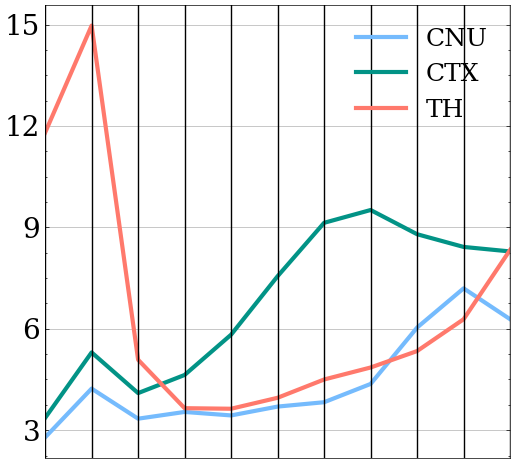

In [11]:
# split_num=4
# topath_f='./br_seq_nor_feas.csv'
if True:
    split_feas=['S'+str(split_num-x-1) for x in np.arange(split_num)]
    all_ana_data=wbseq_dis.copy()
    ana_stypes_dis=pd.DataFrame(columns=split_feas)
    for stype in ana_stypes:
        ana_stype_df=all_ana_data[all_ana_data.soma_region==stype].copy()
        if stype=='SSp':
            ana_stype_df=all_ana_data[all_ana_data.soma_region.isin(ssp_regions)]
        ana_stypes_dis.loc[stype,:]=ana_stype_df[split_feas].mean()
ana_stypes_dis.loc[ana_stypes_dis.index.isin(cnu_stypes),'brain_region']='CNU'
ana_stypes_dis.loc[ana_stypes_dis.index.isin(ctx_stypes),'brain_region']='CTX'
ana_stypes_dis.loc[ana_stypes_dis.index.isin(th_stypes),'brain_region']='TH'
ana_stypes_dis_show=ana_stypes_dis.groupby(['brain_region']).mean().copy()
ana_stypes_dis_show.reset_index(inplace=True)
# ana_stypes_dis_avg=
ana_stypes_dis_avg=pd.DataFrame(columns=split_feas)
# ana_stypes_dis_avg.loc['avg_ratio',split_feas]=1/split_num
# ana_stypes_dis_avg.loc['avg_ratio','type']='Uniform distribution'
# Plot
fig=plt.figure(figsize=(6,6),dpi=100)
ax=plt.subplot(111)
parallel_coordinates(ana_stypes_dis_show, 'brain_region', color=bcolors,linewidth=3)
# parallel_coordinates(ana_stypes_dis_avg, 'type', color='grey',linewidth=2,linestyle='--')
# ax.plot(x=1+np.arange(len(split_feas)),y=np.ones(len(split_feas))*0.25)
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=20)
ax.yaxis.set_major_locator(MaxNLocator(5))
# Lighten borders
# plt.gca().spines["top"].set_alpha(0)
# plt.gca().spines["bottom"].set_alpha(.3)
# plt.gca().spines["right"].set_alpha(0)
# plt.gca().spines["left"].set_alpha(.3)
plt.xticks([])
plt.legend(fontsize=18)
# plt.title('Parallel Coordinated of Diamonds', fontsize=22)
# plt.grid(alpha=0.6)
# ax.set_axis_off()
plt.show()  
fig.savefig('./figs/bouton_distribution_in_branch_seq_s'+str(split_num)+'.png',dpi=300)

In [ ]:
# multiple cores
brseqsdir='./brseqs'
brbseq_fea_names=['wb_seq_brs_avg','wb_seq_brs_std','wb_seq_brs_min','wb_seq_brs_max',
            'wb_seq_len_avg','wb_seq_len_std','wb_seq_len_min','wb_seq_len_max',
            'wb_seq_tor_avg','wb_seq_tor_std','wb_seq_tor_min','wb_seq_tor_max',
            'wb_seq_bnum_avg','wb_seq_bnum_std','wb_seq_bnum_min','wb_seq_bnum_max',
            'wb_seq_brbnum_avg','wb_seq_brbnum_std','wb_seq_ibd_avg','wb_seq_ibd_std',
            'nb_seq_brs_avg','nb_seq_brs_std','nb_seq_brs_min','nb_seq_brs_max',
            'nb_seq_len_avg','nb_seq_len_std','nb_seq_len_min','nb_seq_len_max',
            'nb_seq_tor_avg','nb_seq_tor_std','nb_seq_tor_min','nb_seq_tor_max']
def bouton_cluster_analysis(name,para):
    file_in=para
    mfile=file_in.split('/')[-1]
    fname=mfile.split('.eswc')[0]
    topath=os.path.join(brseqsdir,fname+'.csv')
    if os.path.exists(topath):
        return {name:1}
    brfea_raw=pd.read_csv(file_in,index_col=['id'])
    # get tip-brs
    tips=[]
    for br in brfea_raw.index:
        if br in brfea_raw['parent_id'].to_list():
            continue
        tips.append(br)
    #label bouton-seq and no-bouton-seq
    bouton_seq=pd.DataFrame(index=np.arange(1,1+brfea_raw['level'].max()))
    ibd_seq=pd.DataFrame(index=np.arange(1,1+brfea_raw['level'].max()))
    br_len_seq=pd.DataFrame(index=np.arange(1,1+brfea_raw['level'].max()))
    br_tor_seq=pd.DataFrame(index=np.arange(1,1+brfea_raw['level'].max()))
    br_i=0
    for br in tips:
        bseq=[]
        ibdseq=[]
        brlen_seq=[]
        brtor_seq=[]
        bseq.append(brfea_raw.loc[br,'bnum'])
        ibdseq.append(brfea_raw.loc[br,'interb_dist'])
        brlen_seq.append(brfea_raw.loc[br,'pathlength'])
        brtor_seq.append(1-brfea_raw.loc[br,'contraction'])
        pbr=brfea_raw.loc[br,'parent_id']
        while pbr in brfea_raw.index:
            bseq.append(brfea_raw.loc[pbr,'bnum'])
            ibdseq.append(brfea_raw.loc[pbr,'interb_dist'])
            brlen_seq.append(brfea_raw.loc[pbr,'pathlength'])
            brtor_seq.append(1-brfea_raw.loc[pbr,'contraction'])
            br=pbr
            pbr=brfea_raw.loc[br,'parent_id']
        if np.sum(bseq) <=0:
            continue
        while len(bseq) != bouton_seq.shape[0]:
            bseq.append(-1)
            ibdseq.append(-1)
            brlen_seq.append(-1)
            brtor_seq.append(-1)
        br_i+=1
        bseqdf=pd.Series(bseq,name=br_i)
        bouton_seq=pd.concat([bouton_seq,bseqdf],axis=1)
        ibdseqdf=pd.Series(ibdseq,name=br_i)
        ibd_seq=pd.concat([ibd_seq,ibdseqdf],axis=1)
        brlen_seqdf=pd.Series(brlen_seq,name=br_i)
        br_len_seq=pd.concat([br_len_seq,brlen_seqdf],axis=1)
        brtor_seqdf=pd.Series(brtor_seq,name=br_i)
        br_tor_seq=pd.concat([br_tor_seq,brtor_seqdf],axis=1)
    inseq=bouton_seq.copy()
    #1, get wb_seq and nb_seq
    wb_seqs=[]
    wb_seqs_ibd=[]
    wb_seqs_len=[]
    wb_seqs_tor=[]
    nb_seqs=[]
    nb_seqs_len=[]
    nb_seqs_tor=[]
    for seq in inseq.keys():
        wbseq=[]
        nbseq=[]
        nbseq_len=[]
        nbseq_tor=[]
        wb_seq_ibd=[]
        wb_seq_len=[]
        wb_seq_tor=[]
        for br in inseq.index:
            # brunit=inseq.loc[inseq.index.to_list()[inseq.shape[0]-1-bri],seq]
            if inseq.loc[inseq.index>=br,seq].max() > 0:
                wbseq.append(inseq.loc[br,seq])
                wb_seq_ibd.append(ibd_seq.loc[br,seq])
                wb_seq_len.append(br_len_seq.loc[br,seq])
                wb_seq_tor.append(br_tor_seq.loc[br,seq])
            elif inseq.loc[inseq.index>=br,seq].max() == 0:
                nbseq.append(inseq.loc[br,seq])
                nbseq_len.append(br_len_seq.loc[br,seq])
                nbseq_tor.append(br_tor_seq.loc[br,seq])
            else:
                break
        if len(wbseq)>0:
            wb_seqs.append(wbseq)
            wb_seqs_ibd.append(wb_seq_ibd)
            wb_seqs_len.append(wb_seq_len)
            wb_seqs_tor.append(wb_seq_tor)
        if len(nbseq)>0:
            nb_seqs.append(nbseq)
            nb_seqs_len.append(nbseq_len)
            nb_seqs_tor.append(nbseq_tor)
    wb_seq_brs_list=[]
    wb_seq_bnum_list=[]
    wb_seq_brbnum_avg_list=[]
    wb_seq_brbnum_std_list=[]
    for wbseq in wb_seqs:
        wb_seq_brs_list.append(len(wbseq))
        wb_seq_bnum_list.append(np.sum(wbseq))
        wb_seq_brbnum_avg_list.append(np.mean(wbseq))
        wb_seq_brbnum_std_list.append(np.std(wbseq))
    wb_seq_ibd_list=[]
    for wbseq in wb_seqs_ibd:
        wb_seq_ibd_list.append(np.mean(wbseq))
    wb_seq_len_list=[]
    for wbseq in wb_seqs_len:
        wb_seq_len_list.append(np.mean(wbseq))
    wb_seq_tor_list=[]
    for wbseq in wb_seqs_tor:
        wb_seq_tor_list.append(np.mean(wbseq))
    nb_seq_brs_list=[]
    for nbseq in nb_seqs:
        nb_seq_brs_list.append(len(nbseq))
    nb_seq_len_list=[]
    for nbseq in nb_seqs_len:
        nb_seq_len_list.append(np.mean(nbseq))
    nb_seq_tor_list=[]
    for nbseq in nb_seqs_tor:
        nb_seq_tor_list.append(np.mean(nbseq))
        
    # branch number in without-bouton-seq
    nb_seq_brs_avg=np.mean(nb_seq_brs_list) if len(nb_seq_brs_list) else 0
    nb_seq_brs_std=np.std(nb_seq_brs_list) if len(nb_seq_brs_list) else 0
    nb_seq_brs_min=np.min(nb_seq_brs_list) if len(nb_seq_brs_list) else 0
    nb_seq_brs_max=np.max(nb_seq_brs_list) if len(nb_seq_brs_list) else 0
    # branch length in without-bouton-seq
    nb_seq_len_avg=np.mean(nb_seq_len_list) if len(nb_seq_len_list) else 0
    nb_seq_len_std=np.std(nb_seq_len_list) if len(nb_seq_len_list) else 0
    nb_seq_len_min=np.min(nb_seq_len_list) if len(nb_seq_len_list) else 0
    nb_seq_len_max=np.max(nb_seq_len_list) if len(nb_seq_len_list) else 0
    # branch tortuosity in without-bouton-seq
    nb_seq_tor_avg=np.mean(nb_seq_tor_list) if len(nb_seq_tor_list) else 0
    nb_seq_tor_std=np.std(nb_seq_tor_list) if len(nb_seq_tor_list) else 0
    nb_seq_tor_min=np.min(nb_seq_tor_list) if len(nb_seq_tor_list) else 0
    nb_seq_tor_max=np.max(nb_seq_tor_list) if len(nb_seq_tor_list) else 0
    # branch number in with-bouton-seq
    wb_seq_brs_avg=np.mean(wb_seq_brs_list) if len(wb_seq_brs_list) else 0
    wb_seq_brs_std=np.std(wb_seq_brs_list) if len(wb_seq_brs_list) else 0
    wb_seq_brs_min=np.min(wb_seq_brs_list) if len(wb_seq_brs_list) else 0
    wb_seq_brs_max=np.max(wb_seq_brs_list) if len(wb_seq_brs_list) else 0
    # branch length in with-bouton-seq
    wb_seq_len_avg=np.mean(wb_seq_len_list) if len(wb_seq_len_list) else 0
    wb_seq_len_std=np.std(wb_seq_len_list) if len(wb_seq_len_list) else 0
    wb_seq_len_min=np.min(wb_seq_len_list) if len(wb_seq_len_list) else 0
    wb_seq_len_max=np.max(wb_seq_len_list) if len(wb_seq_len_list) else 0
    # branch tortuosity in with-bouton-seq
    wb_seq_tor_avg=np.mean(wb_seq_tor_list) if len(wb_seq_tor_list) else 0
    wb_seq_tor_std=np.std(wb_seq_tor_list) if len(wb_seq_tor_list) else 0
    wb_seq_tor_min=np.min(wb_seq_tor_list) if len(wb_seq_tor_list) else 0
    wb_seq_tor_max=np.max(wb_seq_tor_list) if len(wb_seq_tor_list) else 0
    # IBD in without-bouton-seq
    wb_seq_ibd_avg=np.mean(wb_seq_ibd_list) if len(wb_seq_ibd_list) else 0
    wb_seq_ibd_std=np.std(wb_seq_ibd_list) if len(wb_seq_ibd_list) else 0
    # total bouton number in with-bouton-seq
    wb_seq_bnum_avg=np.mean(wb_seq_bnum_list) if len(wb_seq_bnum_list) else 0
    wb_seq_bnum_std=np.std(wb_seq_bnum_list) if len(wb_seq_bnum_list) else 0
    wb_seq_bnum_min=np.min(wb_seq_bnum_list) if len(wb_seq_bnum_list) else 0
    wb_seq_bnum_max=np.max(wb_seq_bnum_list) if len(wb_seq_bnum_list) else 0
    # avg and std bouton number in with-bouton-seq-br
    wb_seq_brbnum_avg=np.mean(wb_seq_brbnum_avg_list)
    wb_seq_brbnum_std=np.mean(wb_seq_brbnum_std_list)
    brbseqfea=[wb_seq_brs_avg,wb_seq_brs_std,wb_seq_brs_min,wb_seq_brs_max,
            wb_seq_len_avg,wb_seq_len_std,wb_seq_len_min,wb_seq_len_max,
            wb_seq_tor_avg,wb_seq_tor_std,wb_seq_tor_min,wb_seq_tor_max,
            wb_seq_bnum_avg,wb_seq_bnum_std,wb_seq_bnum_min,wb_seq_bnum_max,
            wb_seq_brbnum_avg,wb_seq_brbnum_std,wb_seq_ibd_avg,wb_seq_ibd_std,
            nb_seq_brs_avg,nb_seq_brs_std,nb_seq_brs_min,nb_seq_brs_max,
            nb_seq_len_avg,nb_seq_len_std,nb_seq_len_min,nb_seq_len_max,
            nb_seq_tor_avg,nb_seq_tor_std,nb_seq_tor_min,nb_seq_tor_max]
    brbseqfeas=pd.Series(brbseqfea,name=fname,index=brbseq_fea_names)
    # brbseqfeas.index.name='name'
    brbseqfeas.to_csv(topath)
    return {name:1}

para_dict={}
brfea_dir='./brfeas'
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        if mfile == '.DS_Store':
                continue
        file_in=os.path.join(root,mfile)
        
        fname=mfile.split('.eswc')[0]
        file_out=os.path.join(brseqsdir,fname+'.csv')
        if os.path.exists(file_out):
            continue
        para_dict[mfile]=file_in
        # outlist.append(file_out)
print(len(para_dict))

import multiprocessing as mp

num_cores = int(mp.cpu_count())
pool = mp.Pool(num_cores-2)
results = [pool.apply_async(bouton_cluster_analysis,args=(name,para)) for name,para in para_dict.items()]
results = [p.get() for p in results]

In [ ]:
# extraction of bouton-number change from tip-branch to stem
# 这里是不是有个问题，我是从tip-branch开始统计的，并不保证tip-branch一定是with-bouton branch，所以with-bouton-branch sequence size上是有偏差的
def read_br_seq(file_in):
    brfea_raw=pd.read_csv(file_in,index_col=['id'])
    # get tip-brs
    tips=[]
    for br in brfea_raw.index:
        if br in brfea_raw['parent_id'].to_list():
            continue
        tips.append(br)
    #label bouton-seq and no-bouton-seq
    bouton_seq=pd.DataFrame(index=np.arange(1,1+brfea_raw['level'].max()))
    ibd_seq=pd.DataFrame(index=np.arange(1,1+brfea_raw['level'].max()))
    br_len_seq=pd.DataFrame(index=np.arange(1,1+brfea_raw['level'].max()))
    br_tor_seq=pd.DataFrame(index=np.arange(1,1+brfea_raw['level'].max()))
    br_i=0
    for br in tips:
        bseq=[]
        ibdseq=[]
        brlen_seq=[]
        brtor_seq=[]
        bseq.append(brfea_raw.loc[br,'bnum'])
        ibdseq.append(brfea_raw.loc[br,'interb_dist'])
        brlen_seq.append(brfea_raw.loc[br,'pathlength'])
        brtor_seq.append(1-brfea_raw.loc[br,'contraction'])
        pbr=brfea_raw.loc[br,'parent_id']
        while pbr in brfea_raw.index:
            bseq.append(brfea_raw.loc[pbr,'bnum'])
            ibdseq.append(brfea_raw.loc[pbr,'interb_dist'])
            brlen_seq.append(brfea_raw.loc[pbr,'pathlength'])
            brtor_seq.append(1-brfea_raw.loc[pbr,'contraction'])
            br=pbr
            pbr=brfea_raw.loc[br,'parent_id']
        if np.sum(bseq) <=0:
            continue
        while len(bseq) != bouton_seq.shape[0]:
            bseq.append(-1)
            ibdseq.append(-1)
            brlen_seq.append(-1)
            brtor_seq.append(-1)
        br_i+=1
        bseqdf=pd.Series(bseq,name=br_i)
        bouton_seq=pd.concat([bouton_seq,bseqdf],axis=1)
        ibdseqdf=pd.Series(ibdseq,name=br_i)
        ibd_seq=pd.concat([ibd_seq,ibdseqdf],axis=1)
        brlen_seqdf=pd.Series(brlen_seq,name=br_i)
        br_len_seq=pd.concat([br_len_seq,brlen_seqdf],axis=1)
        brtor_seqdf=pd.Series(brtor_seq,name=br_i)
        br_tor_seq=pd.concat([br_tor_seq,brtor_seqdf],axis=1)
    inseq=bouton_seq.copy()
    #1, get wb_seq and nb_seq
    wb_seqs=[]
    wb_seqs_ibd=[]
    wb_seqs_len=[]
    wb_seqs_tor=[]
    nb_seqs=[]
    nb_seqs_len=[]
    nb_seqs_tor=[]
    for seq in inseq.keys():
        wbseq=[]
        nbseq=[]
        nbseq_len=[]
        nbseq_tor=[]
        wb_seq_ibd=[]
        wb_seq_len=[]
        wb_seq_tor=[]
        for br in inseq.index:
            # brunit=inseq.loc[inseq.index.to_list()[inseq.shape[0]-1-bri],seq]
            if inseq.loc[inseq.index>=br,seq].max() > 0:
                wbseq.append(inseq.loc[br,seq])
                wb_seq_ibd.append(ibd_seq.loc[br,seq])
                wb_seq_len.append(br_len_seq.loc[br,seq])
                wb_seq_tor.append(br_tor_seq.loc[br,seq])
            elif inseq.loc[inseq.index>=br,seq].max() == 0:
                nbseq.append(inseq.loc[br,seq])
                nbseq_len.append(br_len_seq.loc[br,seq])
                nbseq_tor.append(br_tor_seq.loc[br,seq])
            else:
                break
        if len(wbseq)>0:
            wb_seqs.append(wbseq)
            wb_seqs_ibd.append(wb_seq_ibd)
            wb_seqs_len.append(wb_seq_len)
            wb_seqs_tor.append(wb_seq_tor)
        if len(nbseq)>0:
            nb_seqs.append(nbseq)
            nb_seqs_len.append(nbseq_len)
            nb_seqs_tor.append(nbseq_tor)
    wb_seq_brs_list=[]
    wb_seq_bnum_list=[]
    wb_seq_brbnum_avg_list=[]
    wb_seq_brbnum_std_list=[]
    for wbseq in wb_seqs:
        wb_seq_brs_list.append(len(wbseq))
        wb_seq_bnum_list.append(np.sum(wbseq))
        wb_seq_brbnum_avg_list.append(np.mean(wbseq))
        wb_seq_brbnum_std_list.append(np.std(wbseq))
    wb_seq_ibd_list=[]
    for wbseq in wb_seqs_ibd:
        wb_seq_ibd_list.append(np.mean(wbseq))
    wb_seq_len_list=[]
    for wbseq in wb_seqs_len:
        wb_seq_len_list.append(np.mean(wbseq))
    wb_seq_tor_list=[]
    for wbseq in wb_seqs_tor:
        wb_seq_tor_list.append(np.mean(wbseq))
    nb_seq_brs_list=[]
    for nbseq in nb_seqs:
        nb_seq_brs_list.append(len(nbseq))
    nb_seq_len_list=[]
    for nbseq in nb_seqs_len:
        nb_seq_len_list.append(np.mean(nbseq))
    nb_seq_tor_list=[]
    for nbseq in nb_seqs_tor:
        nb_seq_tor_list.append(np.mean(nbseq))
        
    # branch number in without-bouton-seq
    nb_seq_brs_avg=np.mean(nb_seq_brs_list) if len(nb_seq_brs_list) else 0
    nb_seq_brs_std=np.std(nb_seq_brs_list) if len(nb_seq_brs_list) else 0
    nb_seq_brs_min=np.min(nb_seq_brs_list) if len(nb_seq_brs_list) else 0
    nb_seq_brs_max=np.max(nb_seq_brs_list) if len(nb_seq_brs_list) else 0
    # branch length in without-bouton-seq
    nb_seq_len_avg=np.mean(nb_seq_len_list) if len(nb_seq_len_list) else 0
    nb_seq_len_std=np.std(nb_seq_len_list) if len(nb_seq_len_list) else 0
    nb_seq_len_min=np.min(nb_seq_len_list) if len(nb_seq_len_list) else 0
    nb_seq_len_max=np.max(nb_seq_len_list) if len(nb_seq_len_list) else 0
    # branch tortuosity in without-bouton-seq
    nb_seq_tor_avg=np.mean(nb_seq_tor_list) if len(nb_seq_tor_list) else 0
    nb_seq_tor_std=np.std(nb_seq_tor_list) if len(nb_seq_tor_list) else 0
    nb_seq_tor_min=np.min(nb_seq_tor_list) if len(nb_seq_tor_list) else 0
    nb_seq_tor_max=np.max(nb_seq_tor_list) if len(nb_seq_tor_list) else 0
    # branch number in with-bouton-seq
    wb_seq_brs_avg=np.mean(wb_seq_brs_list) if len(wb_seq_brs_list) else 0
    wb_seq_brs_std=np.std(wb_seq_brs_list) if len(wb_seq_brs_list) else 0
    wb_seq_brs_min=np.min(wb_seq_brs_list) if len(wb_seq_brs_list) else 0
    wb_seq_brs_max=np.max(wb_seq_brs_list) if len(wb_seq_brs_list) else 0
    # branch length in with-bouton-seq
    wb_seq_len_avg=np.mean(wb_seq_len_list) if len(wb_seq_len_list) else 0
    wb_seq_len_std=np.std(wb_seq_len_list) if len(wb_seq_len_list) else 0
    wb_seq_len_min=np.min(wb_seq_len_list) if len(wb_seq_len_list) else 0
    wb_seq_len_max=np.max(wb_seq_len_list) if len(wb_seq_len_list) else 0
    # branch tortuosity in with-bouton-seq
    wb_seq_tor_avg=np.mean(wb_seq_tor_list) if len(wb_seq_tor_list) else 0
    wb_seq_tor_std=np.std(wb_seq_tor_list) if len(wb_seq_tor_list) else 0
    wb_seq_tor_min=np.min(wb_seq_tor_list) if len(wb_seq_tor_list) else 0
    wb_seq_tor_max=np.max(wb_seq_tor_list) if len(wb_seq_tor_list) else 0
    # IBD in without-bouton-seq
    wb_seq_ibd_avg=np.mean(wb_seq_ibd_list) if len(wb_seq_ibd_list) else 0
    wb_seq_ibd_std=np.std(wb_seq_ibd_list) if len(wb_seq_ibd_list) else 0
    # total bouton number in with-bouton-seq
    wb_seq_bnum_avg=np.mean(wb_seq_bnum_list) if len(wb_seq_bnum_list) else 0
    wb_seq_bnum_std=np.std(wb_seq_bnum_list) if len(wb_seq_bnum_list) else 0
    wb_seq_bnum_min=np.min(wb_seq_bnum_list) if len(wb_seq_bnum_list) else 0
    wb_seq_bnum_max=np.max(wb_seq_bnum_list) if len(wb_seq_bnum_list) else 0
    # avg and std bouton number in with-bouton-seq-br
    wb_seq_brbnum_avg=np.mean(wb_seq_brbnum_avg_list)
    wb_seq_brbnum_std=np.mean(wb_seq_brbnum_std_list)
    return [wb_seq_brs_avg,wb_seq_brs_std,wb_seq_brs_min,wb_seq_brs_max,
            wb_seq_len_avg,wb_seq_len_std,wb_seq_len_min,wb_seq_len_max,
            wb_seq_tor_avg,wb_seq_tor_std,wb_seq_tor_min,wb_seq_tor_max,
            wb_seq_bnum_avg,wb_seq_bnum_std,wb_seq_bnum_min,wb_seq_bnum_max,
            wb_seq_brbnum_avg,wb_seq_brbnum_std,wb_seq_ibd_avg,wb_seq_ibd_std,
            nb_seq_brs_avg,nb_seq_brs_std,nb_seq_brs_min,nb_seq_brs_max,
            nb_seq_len_avg,nb_seq_len_std,nb_seq_len_min,nb_seq_len_max,
            nb_seq_tor_avg,nb_seq_tor_std,nb_seq_tor_min,nb_seq_tor_max]
brfea_dir='./brfeas'
# brbfeas=pd.DataFrame(columns=brbrfeas_col_labels)
brbseq_fea_names=['wb_seq_brs_avg','wb_seq_brs_std','wb_seq_brs_min','wb_seq_brs_max',
            'wb_seq_len_avg','wb_seq_len_std','wb_seq_len_min','wb_seq_len_max',
            'wb_seq_tor_avg','wb_seq_tor_std','wb_seq_tor_min','wb_seq_tor_max',
            'wb_seq_bnum_avg','wb_seq_bnum_std','wb_seq_bnum_min','wb_seq_bnum_max',
            'wb_seq_brbnum_avg','wb_seq_brbnum_std','wb_seq_ibd_avg','wb_seq_ibd_std',
            'nb_seq_brs_avg','nb_seq_brs_std','nb_seq_brs_min','nb_seq_brs_max',
            'nb_seq_len_avg','nb_seq_len_std','nb_seq_len_min','nb_seq_len_max',
            'nb_seq_tor_avg','nb_seq_tor_std','nb_seq_tor_min','nb_seq_tor_max']
# brbseqfeas=pd.DataFrame(columns=brbseq_fea_names)
# for root,dirs,files in os.walk(brfea_dir):
#     for mfile in files:
#         # print(mfile)
#         if os.path.splitext(mfile)[1] != '.csv':
#             continue
#         file_in=os.path.join(root,mfile)
#         brbseqfea=read_br_seq(file_in=file_in)
#         fname=mfile.split('.eswc')[0]
#         if fname in brbseqfeas.index:
#             continue
#         brbseqfeas.loc[fname,:]=brbseqfea
#         # break


In [17]:
# brbseqfeas[['nb_seq_tor_std','nb_seq_len_std','nb_seq_brs_std']]
brbseqfeas=pd.DataFrame(columns=brbseq_fea_names)
for root,dirs,files in os.walk(brseqsdir):
    for mfile in files:
        # print(mfile)
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        brbseqfea=pd.read_csv(file_in,index_col=0)
        fname=mfile.split('.eswc')[0]
        if fname in brbseqfeas.index:
            continue
        brbseqfeas=pd.concat([brbseqfeas,brbseqfea.T],axis=0)
        # break
brbseqfeas.index.name='name'
brbseqfeas['soma_region']=morpho_feas['soma_region']
brbseqfeas.loc[:,'brain_region']= 'Other'
brbseqfeas.loc[brbseqfeas['soma_region'].isin(CNU),'brain_region']= 'CNU'
brbseqfeas.loc[brbseqfeas['soma_region'].isin(CTX),'brain_region']= 'CTX'
brbseqfeas.loc[brbseqfeas['soma_region'].isin(TH),'brain_region']= 'TH'
brbseqfeas.to_csv('./br_seq_feas.csv',float_format='%.3f')
brbseqfeas.keys()

Index(['wb_seq_brs_avg', 'wb_seq_brs_std', 'wb_seq_brs_min', 'wb_seq_brs_max',
       'wb_seq_len_avg', 'wb_seq_len_std', 'wb_seq_len_min', 'wb_seq_len_max',
       'wb_seq_tor_avg', 'wb_seq_tor_std', 'wb_seq_tor_min', 'wb_seq_tor_max',
       'wb_seq_bnum_avg', 'wb_seq_bnum_std', 'wb_seq_bnum_min',
       'wb_seq_bnum_max', 'wb_seq_brbnum_avg', 'wb_seq_brbnum_std',
       'wb_seq_ibd_avg', 'wb_seq_ibd_std', 'nb_seq_brs_avg', 'nb_seq_brs_std',
       'nb_seq_brs_min', 'nb_seq_brs_max', 'nb_seq_len_avg', 'nb_seq_len_std',
       'nb_seq_len_min', 'nb_seq_len_max', 'nb_seq_tor_avg', 'nb_seq_tor_std',
       'nb_seq_tor_min', 'nb_seq_tor_max', 'soma_region', 'brain_region'],
      dtype='object')

In [18]:
brbseqfeas.head(5)

,wb_seq_brs_avg,wb_seq_brs_std,wb_seq_brs_min,wb_seq_brs_max,wb_seq_len_avg,wb_seq_len_std,wb_seq_len_min,wb_seq_len_max,wb_seq_tor_avg,wb_seq_tor_std,...,nb_seq_len_avg,nb_seq_len_std,nb_seq_len_min,nb_seq_len_max,nb_seq_tor_avg,nb_seq_tor_std,nb_seq_tor_min,nb_seq_tor_max,soma_region,brain_region
name,,,,,,,,,,,,,,,,,,,,,
18453_3810_x16082_y20891,15.441860,7.199168,4.0,31.0,82.399225,15.176113,40.895520,142.688094,0.195266,0.032021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,OT,CNU
18453_1643_x24077_y11694,6.777358,3.413549,1.0,15.0,283.547570,217.146987,22.419670,1319.746600,0.115692,0.041167,...,28.677074,6.369226,19.086362,38.571695,0.020485,7.282744e-03,0.015090,0.048534,MOs,CTX
17302_00096,12.942308,6.866623,5.0,28.0,125.450372,51.509417,47.212600,244.500802,0.232155,0.035014,...,11.940100,0.000000,11.940100,11.940100,0.185906,5.551115e-17,0.185906,0.185906,CP,CNU
18458_00443,15.302564,4.019918,2.0,24.0,303.750086,75.932455,104.788309,596.250486,0.157717,0.026245,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,VPM,TH
18465_00116,22.757576,15.740100,1.0,54.0,108.379295,45.041034,13.361700,346.198750,0.128119,0.027608,...,810.878670,154.763766,261.128107,1612.849640,0.207803,4.067611e-02,0.071544,0.364115,LGd,TH


### bouton density in branch-level
1. based on branch size, split w_bouton branch sequence into 4 parts
2. get bouton number

In [ ]:
'''w seq size VS w/o seq size'''
for bt in btype:
    fig=plt.figure(figsize=(4,4),dpi=100)
    fs=16
    plt.subplot(111)

    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='nb_seq_len_avg',fill=True,linewidth=3,
                color='black',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='wb_seq_len_avg',fill=True,linewidth=3,
                color='red',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax.tick_params(axis='x',labelsize=20)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(axis='y',labelsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(top=False,right=False)
    # ax.yaxis.set_minor_locator(MaxNLocator(1))
    # ax.set_axis_off()
    # plt.legend(['CTX','TH','CNU'],title='',fontsize=fs,loc='upper right')
    plt.xlabel('',fontsize=fs+2)
    plt.ylabel('',fontsize=fs+2)
    plt.xlim([-200,1500])
    # plt.xlim([-0.1,0.4])
    plt.ylim([0,0.013])
    # ax.set_yscale('log')
    # plt.title(bt,fontsize=20,y=0.85)
    plt.gca().spines["top"].set_alpha(.0)
    # plt.gca().spines["bottom"].set_alpha(.0)
    plt.gca().spines["right"].set_alpha(.0)
    # plt.gca().spines["left"].set_alpha(.0)
    plt.show()
    fig.savefig('./figs/branch_seq_len_cmp_'+bt+'.png',dpi=300)

### comparsion of two kind of branch sequence
1. branch size
2. branch length
3. branch torturisity

In [242]:
brbseqfeas[['wb_seq_brs_avg','nb_seq_brs_avg','brain_region']].groupby('brain_region').mean()

,wb_seq_brs_avg,nb_seq_brs_avg
brain_region,,
CNU,13.989478,1.520035
CTX,12.103092,2.936162
Other,11.126173,1.917539
TH,11.793039,6.798736


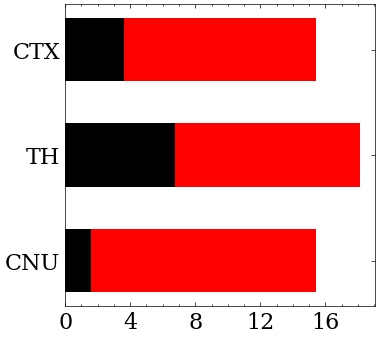

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,4),dpi=100)
w=0.6
fs=16
bpla=sns.color_palette(bcolors)
sdata=brbseqfeas[brbseqfeas.soma_region.isin(ana_regions)].copy()
showdata=sdata[['nb_seq_brs_avg','wb_seq_brs_avg','brain_region']].groupby('brain_region').mean()
b=np.zeros(3)
scolors=['black','red']
for i,key in enumerate(['nb_seq_brs_avg','wb_seq_brs_avg']):
    ratios=[showdata.loc[bt,key] for bt in btype]
    ax.barh(btype,ratios,height=w,left=b,color=scolors[i],fill=True)
    b+=ratios
# plt.ylim([0,1])
ax.tick_params(axis='x',labelsize=fs)
ax.tick_params(axis='y',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(MaxNLocator(1))
plt.show()
fig.savefig('./figs/bouton_seq_cmp.png',dpi=300)

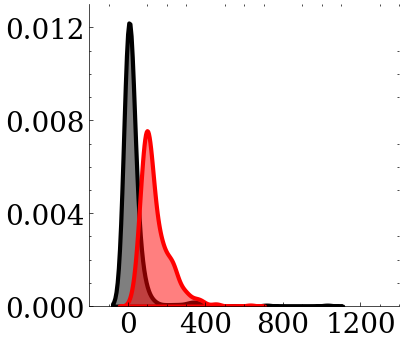

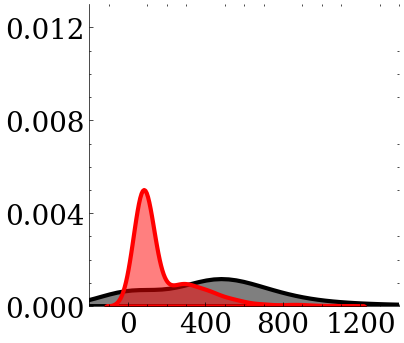

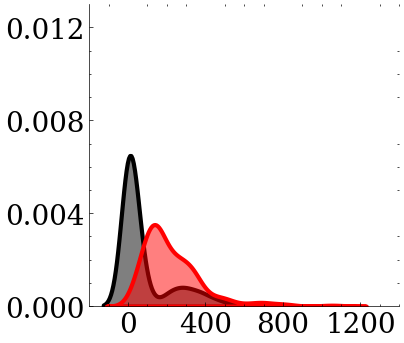

In [23]:
'''w seq size VS w/o seq size'''
for bt in btype:
    fig=plt.figure(figsize=(4,4),dpi=100)
    fs=16
    plt.subplot(111)

    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='nb_seq_len_avg',fill=True,linewidth=3,
                color='black',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='wb_seq_len_avg',fill=True,linewidth=3,
                color='red',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax.tick_params(axis='x',labelsize=20)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(axis='y',labelsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(top=False,right=False)
    # ax.yaxis.set_minor_locator(MaxNLocator(1))
    # ax.set_axis_off()
    # plt.legend(['CTX','TH','CNU'],title='',fontsize=fs,loc='upper right')
    plt.xlabel('',fontsize=fs+2)
    plt.ylabel('',fontsize=fs+2)
    plt.xlim([-200,1400])
    # plt.xlim([-0.1,0.4])
    plt.ylim([0,0.013])
    # ax.set_yscale('log')
    # plt.title(bt,fontsize=20,y=0.85)
    plt.gca().spines["top"].set_alpha(.0)
    # plt.gca().spines["bottom"].set_alpha(.0)
    plt.gca().spines["right"].set_alpha(.0)
    # plt.gca().spines["left"].set_alpha(.0)
    plt.show()
    fig.savefig('./figs/branch_seq_len_cmp_'+bt+'.png',dpi=300)

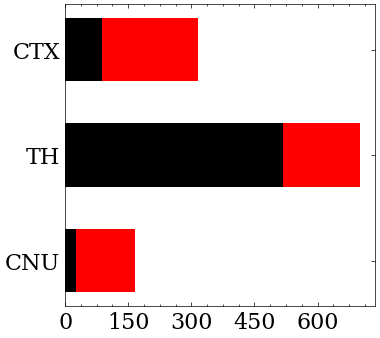

In [284]:
fig, ax = plt.subplots(1,1, figsize=(4,4),dpi=100)
w=0.6
fs=16
bpla=sns.color_palette(bcolors)
sdata=brbseqfeas[brbseqfeas.soma_region.isin(ana_regions)].copy()
showdata=sdata[['nb_seq_len_avg','wb_seq_len_avg','brain_region']].groupby('brain_region').mean()
b=np.zeros(3)
scolors=['black','red']
for i,key in enumerate(['nb_seq_len_avg','wb_seq_len_avg']):
    ratios=[showdata.loc[bt,key] for bt in btype]
    ax.barh(btype,ratios,height=w,left=b,color=scolors[i],fill=True)
    b+=ratios
# plt.ylim([0,1])
ax.tick_params(axis='x',labelsize=fs)
ax.tick_params(axis='y',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(MaxNLocator(1))
plt.show()
# fig.savefig('./figs/bouton_seq_cmp.png',dpi=300)

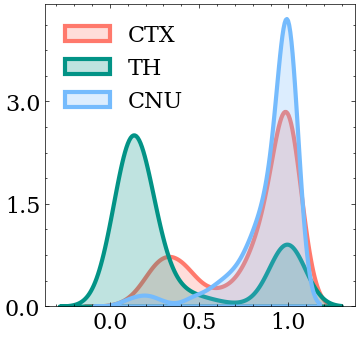

In [240]:
'''w seq size VS w/o seq size'''
fig=plt.figure(figsize=(4,4),dpi=100)
fs=16
plt.subplot(111)
bpla=sns.color_palette(bcolors)
sdata=brbseqfeas[brbseqfeas.soma_region.isin(ana_regions)].copy()
sdata['seq_w_ratio']=sdata['wb_seq_brs_avg']/(sdata['nb_seq_brs_avg']+sdata['wb_seq_brs_avg'])
sdata['seq_w_len_ratio']=sdata['wb_seq_len_avg']/(sdata['nb_seq_len_avg']+sdata['wb_seq_len_avg'])
sdata['seq_w_tor_ratio']=sdata['wb_seq_tor_avg']/(sdata['nb_seq_tor_avg'])
ax=sns.kdeplot(data=sdata,
               x='seq_w_len_ratio',fill=True,linewidth=3,
               hue='brain_region',hue_order=btype,
                palette=bpla,common_norm=False)
ax.tick_params(axis='x',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.tick_params(axis='y',labelsize=fs)
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.legend(['CTX','TH','CNU'],title='',fontsize=fs,loc='upper left')
plt.xlabel('',fontsize=fs+2)
plt.ylabel('',fontsize=fs+2)
# plt.xlim([-500,1000])
# plt.xlim([-5,100])
plt.show()
fig.savefig('./figs/branch_seq_length_ratio.png',dpi=300)

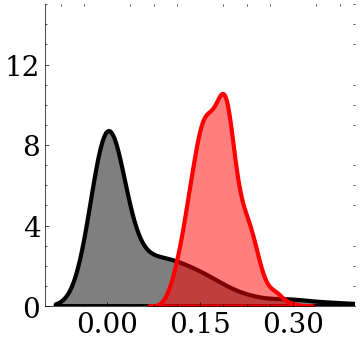

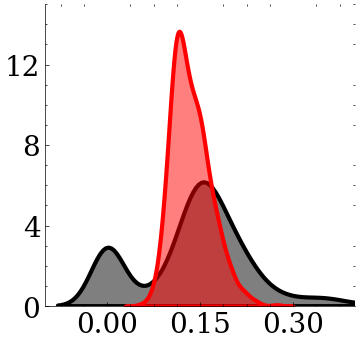

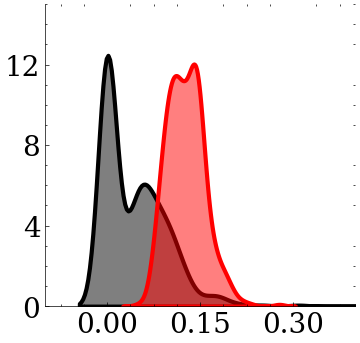

In [24]:
'''w seq size VS w/o seq size'''
for bt in btype:
    fig=plt.figure(figsize=(4,4),dpi=100)
    fs=16
    plt.subplot(111)

    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='nb_seq_tor_avg',fill=True,linewidth=3,
                color='black',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='wb_seq_tor_avg',fill=True,linewidth=3,
                color='red',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax.tick_params(axis='x',labelsize=20)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(axis='y',labelsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(top=False,right=False)
    # ax.yaxis.set_minor_locator(MaxNLocator(1))
    # ax.set_axis_off()
    # plt.legend(['CTX','TH','CNU'],title='',fontsize=fs,loc='upper right')
    plt.xlabel('',fontsize=fs+2)
    plt.ylabel('',fontsize=fs+2)
    # plt.xlim([-500,1000])
    plt.xlim([-0.1,0.4])
    plt.ylim([0,15])
    # plt.title(bt,fontsize=20,y=0.85)
    plt.gca().spines["top"].set_alpha(.0)
    # plt.gca().spines["bottom"].set_alpha(.0)
    plt.gca().spines["right"].set_alpha(.0)
    # plt.gca().spines["left"].set_alpha(.0)
    plt.show()
    fig.savefig('./figs/branch_seq_tor_cmp_'+bt+'.png',dpi=300)

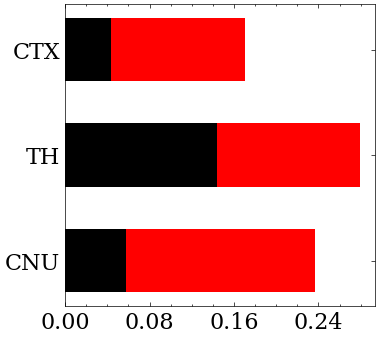

In [286]:
fig, ax = plt.subplots(1,1, figsize=(4,4),dpi=100)
w=0.6
fs=16
bpla=sns.color_palette(bcolors)
sdata=brbseqfeas[brbseqfeas.soma_region.isin(ana_regions)].copy()
showdata=sdata[['nb_seq_tor_avg','wb_seq_tor_avg','brain_region']].groupby('brain_region').mean()
b=np.zeros(3)
scolors=['black','red']
for i,key in enumerate(['nb_seq_tor_avg','wb_seq_tor_avg']):
    ratios=[showdata.loc[bt,key] for bt in btype]
    ax.barh(btype,ratios,height=w,left=b,color=scolors[i],fill=True)
    b+=ratios
# plt.ylim([0,1])
ax.tick_params(axis='x',labelsize=fs)
ax.tick_params(axis='y',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_minor_locator(MaxNLocator(1))
plt.show()
# fig.savefig('./figs/bouton_seq_cmp.png',dpi=300)

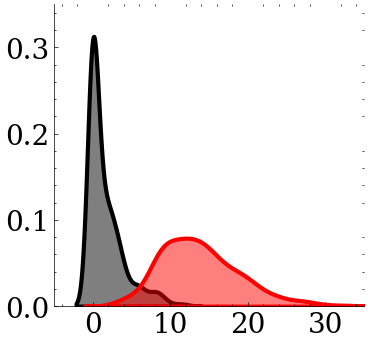

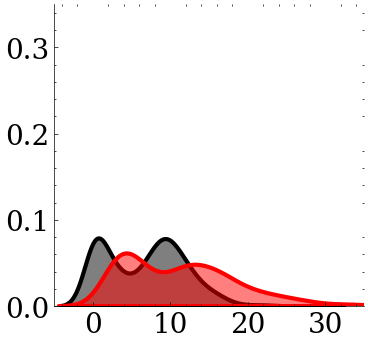

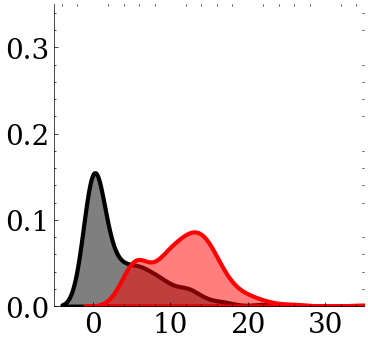

In [25]:
'''w seq size VS w/o seq size'''
for bt in btype:
    fig=plt.figure(figsize=(4,4),dpi=100)
    fs=16
    plt.subplot(111)

    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='nb_seq_brs_avg',fill=True,linewidth=3,
                color='black',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax=sns.kdeplot(data=sdata[sdata.brain_region==bt],
                x='wb_seq_brs_avg',fill=True,linewidth=3,
                color='red',alpha=0.5
                #    hue='brain_region',hue_order=btype,
                #    palette=bpla,common_norm=False
                )
    ax.tick_params(axis='x',labelsize=20)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(axis='y',labelsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(top=False,right=False)
    # ax.yaxis.set_minor_locator(MaxNLocator(1))
    # ax.set_axis_off()
    # plt.legend(['CTX','TH','CNU'],title='',fontsize=fs,loc='upper right')
    plt.xlabel('',fontsize=fs+2)
    plt.ylabel('',fontsize=fs+2)
    # plt.xlim([-500,1000])
    plt.xlim([-5,35])
    plt.ylim([0,0.35])
    # plt.title('CNU')
    plt.gca().spines["top"].set_alpha(.0)
    # plt.gca().spines["bottom"].set_alpha(.0)
    plt.gca().spines["right"].set_alpha(.0)
    # plt.gca().spines["left"].set_alpha(.0)
    plt.show()
    fig.savefig('./figs/branch_seq_size_cmp_'+bt+'.png',dpi=300)

### bouton distribution in topological related branches

In [26]:
'''
一个branch有bouton, 那其child有bouton的概率是多大?
一个branch的bouton和其parent-branch bouton有什么关系？
'''
def read_br_boutons_v0(file_in):
    brfea_raw=pd.read_csv(file_in,index_col=['id'])
    pbnum_ratios=[]
    for br in brfea_raw.index:
        if brfea_raw.loc[br,'bnum']:
            pbnum=brfea_raw.loc[br,'pbnum']
            pbnum_ratios.append(pbnum/brfea_raw.loc[br,'bnum'])
    if len(pbnum_ratios):
        avg_pbnum_ratios=np.mean(pbnum_ratios)
    else:
        return None
    # get tip-brs
    tips=[]
    for br in brfea_raw.index:
        if br in brfea_raw['parent_id'].to_list():
            continue
        tips.append(br)
    # for none tip-br
    wbbrs=0
    no_child_br_wb=0
    one_child_br_wb=0
    two_child_br_wb=0
    for br in brfea_raw.index:
        if br in tips:
            continue
        if brfea_raw.loc[br,'bnum']:
            wbbrs+=1
            wb_childbr=0
            if brfea_raw.loc[br,'lcbnum']:
                wb_childbr+=1
            if brfea_raw.loc[br,'rcbnum']:
                wb_childbr+=1
            if wb_childbr ==1:
                one_child_br_wb+=1
            elif wb_childbr ==2:
                two_child_br_wb+=1
            else:
                no_child_br_wb+=1
    if wbbrs:
        no_child_br_wb_ratio=no_child_br_wb/wbbrs
        one_child_br_wb_ratio=one_child_br_wb/wbbrs
        two_child_br_wb_ratio=two_child_br_wb/wbbrs
        return [avg_pbnum_ratios,no_child_br_wb_ratio,one_child_br_wb_ratio,two_child_br_wb_ratio]
    else:
        return None
brfea_dir='./brfeas'
brbrfeas_col_labels=['avg_pbnum_ratios','no_child_br_wb_ratio','one_child_br_wb_ratio','two_child_br_wb_ratio']
brbfeas=pd.DataFrame(columns=brbrfeas_col_labels)
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        # print(mfile)
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        brbfea=read_br_boutons_v0(file_in=file_in)
        if brbfea is None:
            continue
        fname=mfile.split('.eswc')[0]
        if fname in brbfeas.index:
            continue
        brbfeas.loc[fname,:]=brbfea
brbfeas.index.name='name'
brbfeas['soma_region']=morpho_feas['soma_region']
brbfeas.loc[:,'brain_region']= 'Other'
brbfeas.loc[brbfeas['soma_region'].isin(CNU),'brain_region']= 'CNU'
brbfeas.loc[brbfeas['soma_region'].isin(CTX),'brain_region']= 'CTX'
brbfeas.loc[brbfeas['soma_region'].isin(TH),'brain_region']= 'TH'
brbfeas.to_csv('./branch_bouton_parent_child.csv',float_format='%.3f')

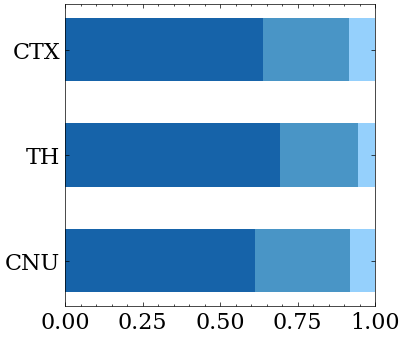

In [27]:
fig, ax = plt.subplots(1,1, figsize=(4,4),dpi=100)
w=0.6
fs=16
sdata=brbfeas[brbfeas.soma_region.isin(ana_regions)].copy()
showdata=sdata[['two_child_br_wb_ratio','one_child_br_wb_ratio','no_child_br_wb_ratio','brain_region']].groupby('brain_region').mean()
b=np.zeros(3)
scolors=['#1663A9','#4995c6','#95d0fc','#d0fefe']
for i,key in enumerate(['two_child_br_wb_ratio','one_child_br_wb_ratio','no_child_br_wb_ratio']):
    ratios=[showdata.loc[bt,key] for bt in btype]
    # ax.bar(btype,ratios,width=w,bottom=b,color=scolors[i],fill=True)
    ax.barh(btype,ratios,height=w,left=b,color=scolors[i],fill=True)
    b+=ratios
plt.xlim([0,1])
ax.tick_params(axis='x',labelsize=fs)
ax.tick_params(axis='y',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_minor_locator(MaxNLocator(1))
plt.show()
fig.savefig('./figs/bouton_distribution_in_topo_related_branch.png',dpi=300)

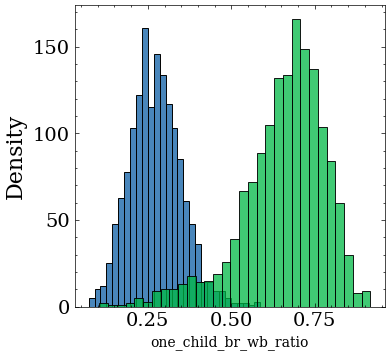

In [138]:
'''w seq size VS w/o seq size'''
fig=plt.figure(figsize=(4,4),dpi=100)
fs=14
plt.subplot(111)
bpla=sns.color_palette(bcolors)
sdata=brbfeas[brbfeas.soma_region.isin(ana_regions)].copy()
ax=sns.histplot(data=sdata,
               x='one_child_br_wb_ratio',
            #    hue='brain_region',hue_order=btype,
                # palette=bpla,common_norm=False
                )
sns.histplot(data=sdata,
               x='two_child_br_wb_ratio',
            #    hue='brain_region',hue_order=btype,
                # palette=bpla,common_norm=False
                )
ax.tick_params(axis='x',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.tick_params(axis='y',labelsize=fs)
ax.yaxis.set_major_locator(MaxNLocator(4))
# plt.legend(['CTX','TH','CNU'],title='',fontsize=fs+2)
# plt.xlabel('Bouton propagation ratio in branch pair',fontsize=fs+2)
plt.ylabel('Density',fontsize=fs+2)
# plt.xlim([-500,1000])
# plt.xlim([0,1.5])
plt.show()
# fig.savefig('./figs/bouton_density_in_branch.png',dpi=300)

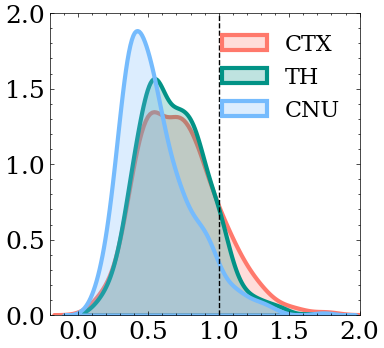

In [28]:
'''w seq size VS w/o seq size'''
fig=plt.figure(figsize=(4,4),dpi=100)
fs=16
plt.subplot(111)
bpla=sns.color_palette(bcolors)
sdata=brbfeas[brbfeas.soma_region.isin(ana_regions)].copy()
ax=sns.kdeplot(data=sdata,
               x='avg_pbnum_ratios',fill=True,linewidth=3,
               hue='brain_region',hue_order=btype,
                palette=bpla,common_norm=False)
ax.tick_params(axis='x',labelsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='y',labelsize=18)
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.legend(['CTX','TH','CNU'],title='',fontsize=16,loc='upper right')
plt.xlabel('',fontsize=fs+2)
plt.ylabel('',fontsize=fs+2)
plt.axvline(x=1,ls='--',c='black')
# plt.xlim([-500,1000])
plt.xlim([-0.2,2])
plt.ylim([0,2])
plt.show()
fig.savefig('./figs/bouton_propagate_ratio_in_pc_branch.png',dpi=300)

## correlation of with-bouton-br and without-bouton-br
with-bouton-br 更长、更弯曲、分叉角度更小


In [251]:
br_boutons.keys()

Index(['id', 'parent_id', 'x', 'y', 'z', 'type', 'level', 'dist2soma',
       'path_dist2soma', 'angle', 'angle_remote', 'angle_io1',
       'angle_io1_remote', 'angle_io2', 'angle_io2_remote', 'radius',
       'lcradius', 'rcradius', 'length', 'pathlength', 'contraction',
       'lclength', 'lcpathlength', 'rclength', 'rcpathlength', 'width',
       'height', 'depth', 'lslength', 'lspathlength', 'rslength',
       'rspathlength', 'lstips', 'rstips', 'bnum', 'lcbnum', 'rcbnum',
       'neigborbs', 'interb_dist'],
      dtype='object')

In [32]:
def read_br_boutons(file_in):
    brfea_raw=pd.read_csv(file_in)
    axonal_brfea=brfea_raw[brfea_raw.type==2].copy()
    withb_brfea=axonal_brfea[axonal_brfea.bnum>0].copy()
    withbbr=axonal_brfea[axonal_brfea.bnum>0].shape[0]
    nobbr=axonal_brfea[axonal_brfea.bnum==0].shape[0]
    bnums=withb_brfea['bnum'].mean()
    w_br_tor=1-withb_brfea.loc[withb_brfea.pathlength>50,'contraction'].mean()
    n_br_tor=1-axonal_brfea.loc[(axonal_brfea.bnum==0)&(axonal_brfea.pathlength>50),'contraction'].mean()
    withb_br_len=withb_brfea['pathlength'].mean()
    nob_br_len=axonal_brfea.loc[axonal_brfea.bnum==0,'pathlength'].mean()
    # withb_br_angle=withb_brfea['angle'].mean()
    withbbif=axonal_brfea[(axonal_brfea.bnum>0)&(axonal_brfea.lstips>0)].shape[0]
    nobbif=axonal_brfea[(axonal_brfea.bnum==0)&(axonal_brfea.lstips>0)].shape[0]
    withb_br_angle=axonal_brfea.loc[(axonal_brfea.bnum>0)&(axonal_brfea.lstips>0),'angle'].mean()
    nob_br_angle=axonal_brfea.loc[(axonal_brfea.bnum==0)&(axonal_brfea.lstips>0),'angle'].mean()
    withb_br_rangle=axonal_brfea.loc[(axonal_brfea.bnum>0)&(axonal_brfea.lstips>0),'angle_remote'].mean()
    nob_br_rangle=axonal_brfea.loc[(axonal_brfea.bnum==0)&(axonal_brfea.lstips>0),'angle_remote'].mean()
    # withb_br_rangle=withb_brfea['angle_remote'].mean()
    # nob_br_rangle=axonal_brfea.loc[axonal_brfea.bnum==0,'angle_remote'].mean()
    return [withbbr,nobbr,bnums,withb_br_len,nob_br_len,w_br_tor,n_br_tor,
            withbbif,nobbif,withb_br_angle,nob_br_angle,withb_br_rangle,nob_br_rangle]
brfea_dir='./brfeas'
brbrfeas_col_labels=['withbbr','nobbr','bnums','withb_br_len','nob_br_len','w_br_tor','n_br_tor',
            'withbbif','nobbif','withb_br_angle','nob_br_angle','withb_br_rangle','nob_br_rangle']
brbfeas=pd.DataFrame(columns=brbrfeas_col_labels)
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        # print(mfile)
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        brbfea=read_br_boutons(file_in=file_in)
        fname=mfile.split('.eswc')[0]
        if fname in brbfeas.index:
            continue
        brbfeas.loc[fname,:]=brbfea
brbfeas.index.name='name'
brbfeas['soma_region']=morpho_feas['soma_region']
brbfeas.loc[:,'brain_region']= 'Other'
brbfeas.loc[brbfeas['soma_region'].isin(CNU),'brain_region']= 'CNU'
brbfeas.loc[brbfeas['soma_region'].isin(CTX),'brain_region']= 'CTX'
brbfeas.loc[brbfeas['soma_region'].isin(TH),'brain_region']= 'TH'
brbfeas.to_csv('./ana_branch_bouton_features.csv',float_format='%.3f')

In [16]:
brbfeas.loc[brbfeas.brain_region=='CNU','bnums'].mean()

4.1660274964560315

In [33]:
brbfeas

,withbbr,nobbr,bnums,withb_br_len,nob_br_len,w_br_tor,n_br_tor,withbbif,nobbif,withb_br_angle,nob_br_angle,withb_br_rangle,nob_br_rangle,soma_region,brain_region
name,,,,,,,,,,,,,,,
17545_00173,189,63,8.084656,130.336712,144.326715,0.175129,0.169903,87,46,64.301264,75.552971,63.102461,79.906167,LGd,TH
17545_00172,167,60,4.790419,79.006715,133.170445,0.194681,0.185452,94,43,74.186573,61.894735,69.536906,61.550881,VPM,TH
18454_00166,178,122,4.820225,96.054813,89.678437,0.111794,0.129086,77,103,82.312644,77.274614,72.08732,73.400987,VPL,TH
pre_17543_01276,52,34,5.365385,354.040858,208.547661,0.186045,0.197134,30,14,66.46582,58.776836,76.7039,64.962671,error,Other
18864_3494_x2380_y13749,291,72,7.804124,266.462622,156.924656,0.20263,0.144565,152,34,72.476021,77.569937,71.038514,80.796061,MOp,CTX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18465_00230,90,53,5.744444,110.80668,140.174471,0.133335,0.139287,41,35,77.10209,82.127929,69.178727,68.795777,VPM,TH
17302_00041,138,63,8.869565,133.868092,159.572821,0.145774,0.187758,74,44,73.063714,71.863445,67.611861,76.792159,LGd,TH
18867_4156_x9348_y9148,149,80,5.362416,102.650691,175.845156,0.205687,0.145169,64,52,79.527653,85.22408,73.989664,84.578515,SSp-m,CTX


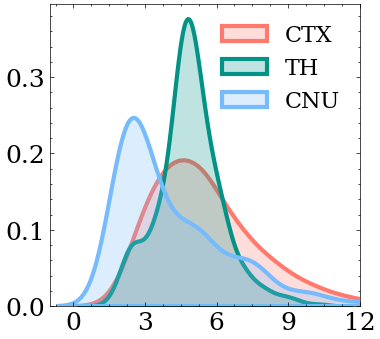

In [16]:
brbfeas=pd.read_csv('./ana_branch_bouton_features.csv',index_col=['name'])
fig=plt.figure(figsize=(4,4),dpi=100)
fs=18
plt.subplot(111)
bpla=sns.color_palette(bcolors)
ax=sns.kdeplot(data=brbfeas[brbfeas.soma_region.isin(ana_regions)],x='bnums',
               fill=True,
                hue='brain_region',hue_order=btype,
                palette=bpla,
                linewidth=3,common_norm=False)
ax.tick_params(axis='x',labelsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='y',labelsize=fs)
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.legend(['CTX','TH','CNU'],title='',fontsize=fs-2)
plt.xlabel('',fontsize=fs)
plt.ylabel('',fontsize=fs+2)
plt.xlim([-1,12])
plt.show()
fig.savefig('./figs/bouton_density_in_branch.png',dpi=300)

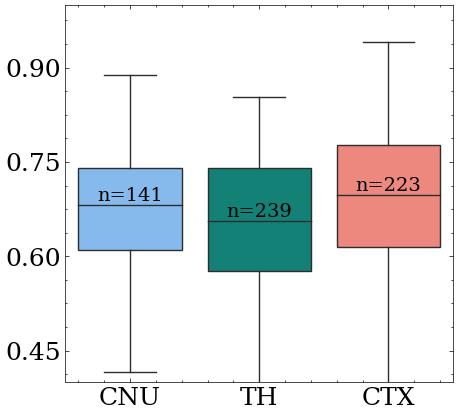

In [22]:
brbfeas['with_no_ratio']=brbfeas['withbbr']/(brbfeas['nobbr']+brbfeas['withbbr'])
brbfeas['total_brs']=(brbfeas['nobbr']+brbfeas['withbbr'])
showdata=brbfeas[brbfeas.soma_region.isin(ana_regions)].copy()
fig=plt.figure(figsize=(5,5),dpi=100)
ax=sns.boxplot(data=showdata,
            x='brain_region',y='with_no_ratio',order=btype,
            palette=bpla,showfliers=False)
# Add N Obs inside boxplot (optional)
if True:
    y='with_no_ratio'
    ynum='total_brs'
    medians_dict = {grp[0]:grp[1][y].median() for grp in showdata.groupby('brain_region')}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = showdata.groupby('brain_region')[ynum].mean()
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        ax.text(x,
                medians_dict[xticklabel]*1.01, 
                "n="+str(math.floor(n_ob*medians_dict[xticklabel])), 
                horizontalalignment='center', fontdict={'size':14}, color='black')

ax.tick_params(axis='x',labelsize=18)
# ax.xaxis.set_major_locator(MaxNLocator(3))
ax.tick_params(axis='y',labelsize=18)
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.ylim([0.4,1])
plt.xlabel('',fontsize=13)
plt.ylabel('',fontsize=13)
# plt.ylabel('With bouton branch ratio',fontsize=18)
plt.show()
fig.savefig('./figs/with_bouton_ratio.png',dpi=300)

In [17]:
# get histogram
def fea_hist(indf,fea='withb_br_len',bin_width=None,bin_num=20):
    if fea not in indf.keys():
        return None
    data=indf.copy()
    if bin_width is None:
        bin_width=data[fea].max()/bin_num
    out=np.zeros(bin_num)
    # print(data)
    for b in np.arange(bin_num):
        l=b*bin_width
        r=(b+1)*bin_width
        if b == bin_num-1:
            r=data[fea].max()
        out[b]=data[(data[fea]>l)&(data[fea]<=r)].shape[0]/data.shape[0]
    return out

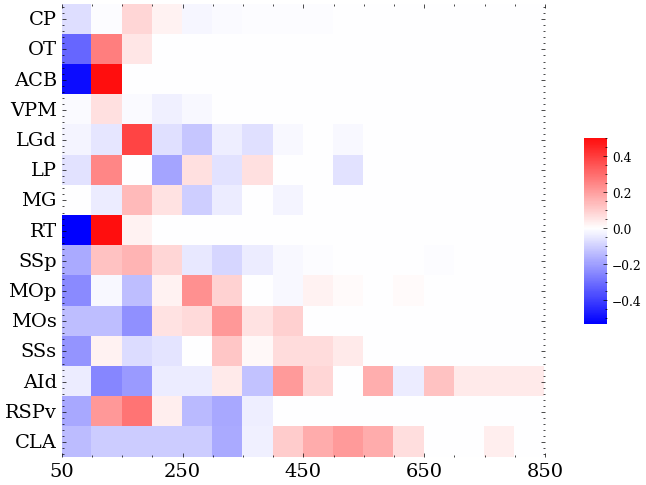

In [1125]:
bin_width=50
bin_num=20
fs=18
feag=['withb_br_len','nob_br_len']
fig=plt.figure(figsize=(10,6),dpi=100)
ax=plt.subplot(111)
brlen_hit_diff=pd.DataFrame()
for ai,astype in enumerate(ana_stypes):
    if astype == 'SSp':
        ana_data=brbfeas[brbfeas.soma_region.isin(ssp_regions)].copy()
    else:
        ana_data=brbfeas[brbfeas.soma_region==astype].copy()
    with_hit=fea_hist(indf=ana_data,fea=feag[0],bin_width=bin_width,bin_num=bin_num)
    without_hit=fea_hist(indf=ana_data,fea=feag[1],bin_width=bin_width,bin_num=bin_num)
    brlen_hit_diff[astype]=with_hit-without_hit
ax=sns.heatmap(brlen_hit_diff.T,cmap='bwr',
               center=0,
               square=True, 
               cbar_kws={
                'orientation':'vertical',
                'fraction':0.03,
                'aspect':8,
                })
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
# ax.set_axis_off()
ax.set_xticks(np.arange(bin_num))
ax.set_xticklabels([str((bin+1)*bin_width) for bin in np.arange(bin_num)])
ax.set_yticklabels(ana_stypes,rotation=0)
ax.xaxis.set_major_locator(MaxNLocator(4))
plt.xlim([0,16])
# plt.grid(axis='y',linestyle=':',linewidth=1)
# plt.rcParams['font.size'] = 19
plt.show()
fig.savefig('./figs/br_len_wo_bouton_diff.png',dpi=300)

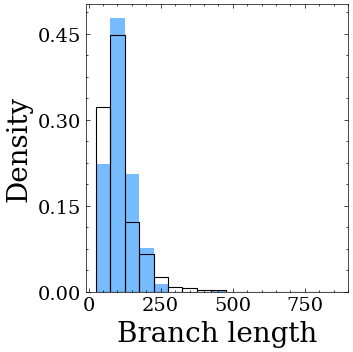

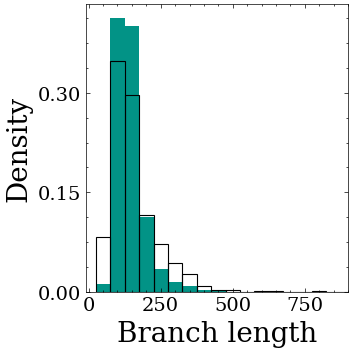

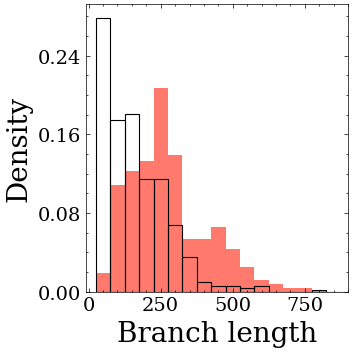

In [1138]:
feag=['withb_br_len','nob_br_len']
bin_num=30
fs=20
for bi,b_type in enumerate(btype):
    data=brbfeas[brbfeas.brain_region==b_type]
    # bin_width=data[feag].max().max()/bin_num
    bin_width=50
    fig = plt.figure(figsize=(4,4),dpi=100)
    ax=plt.subplot(111)
    with_hit=fea_hist(indf=data,fea=feag[0],bin_width=bin_width,bin_num=bin_num)
    without_hit=fea_hist(indf=data,fea=feag[1],bin_width=bin_width,bin_num=bin_num)
    ax.bar(x=np.arange(1,bin_num+1)*bin_width,height=with_hit,width=bin_width,color=bcolors[bi],label='With bouton branch',fill=True)
    ax.bar(x=np.arange(1,bin_num+1)*bin_width,height=without_hit,width=bin_width,color='w',label='Without bouton branch',fill=False)
    # ax.hist(data['withb_br_len'],color=bcolors[bi],fill=True,density=True,label='With bouton branch')
    # ax.hist(data['nob_br_len'],color='grey',fill=False,density=True,label='Without bouton branch')
    # plt.legend(fontsize=12)
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_major_locator(MaxNLocator(4))
    plt.xlim([-10,900])
    # ax.set_yticklabels([str((c+1)*0.25) for c in np.arange(split_num)])
    plt.xlabel('Branch length',fontsize=fs)
    plt.ylabel('Density',fontsize=fs)
    # plt.title(b_type,fontsize=14)
    plt.tight_layout()
    plt.show()
    fig.savefig('./figs/'+b_type+'_branch_length_hist.png',dpi=300)
    # break


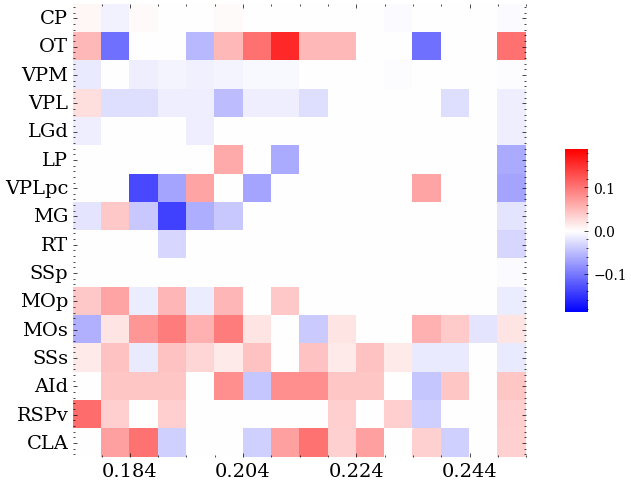

In [20]:
feag=['w_br_tor','n_br_tor']
bin_num=50
fig=plt.figure(figsize=(10,6),dpi=100)
ax=plt.subplot(111)
brlen_hit_diff=pd.DataFrame()
for ai,astype in enumerate(ana_stypes):
    if astype == 'SSp':
        ana_data=brbfeas[brbfeas.soma_region.isin(ssp_regions)].copy()
    else:
        ana_data=brbfeas[brbfeas.soma_region==astype].copy()
    bin_width=ana_data[feag].max().max()/bin_num
    with_hit=fea_hist(indf=ana_data,fea=feag[0],bin_width=bin_width,bin_num=bin_num)
    without_hit=fea_hist(indf=ana_data,fea=feag[1],bin_width=bin_width,bin_num=bin_num)
    brlen_hit_diff[astype]=with_hit-without_hit
ax=sns.heatmap(brlen_hit_diff.T,cmap='bwr',
               center=0,
               square=True, 
               cbar_kws={
                'orientation':'vertical',
                'fraction':0.03,
                'aspect':7,
                })
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
# ax.set_axis_off()
ax.set_xticks(np.arange(bin_num))
ax.set_xticklabels([str(round((bin+1)*bin_width,3)) for bin in np.arange(bin_num)],rotation=0)
ax.xaxis.set_major_locator(MaxNLocator(4))
plt.xlim([34,50])
# plt.grid(axis='y',linestyle=':',linewidth=1)
plt.show()
fig.savefig('./figs/br_tortuo_wo_bouton_diff.png',dpi=300)

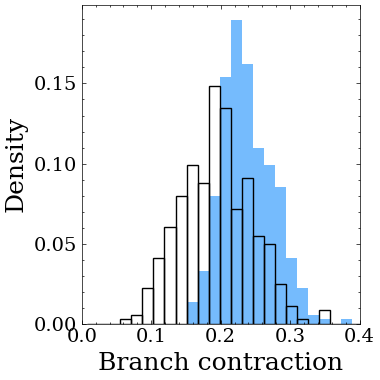

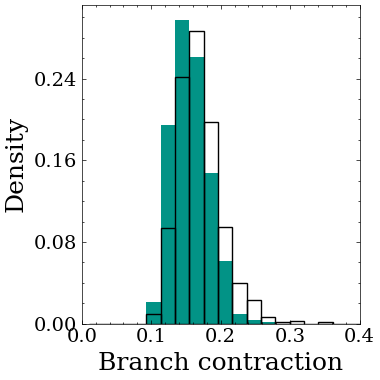

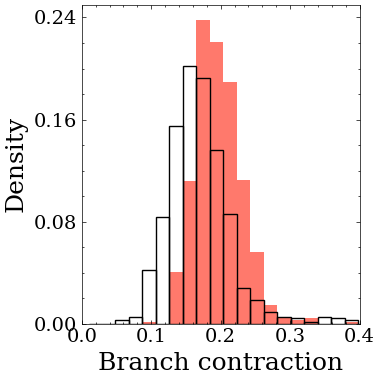

In [23]:
feag=['withb_br_contraction','nob_br_contraction']
bin_num=30
for bi,b_type in enumerate(btype):
    data=brbfeas[brbfeas.brain_region==b_type]
    bin_width=data[feag].max().max()/bin_num
    # bin_width=0.05
    fig = plt.figure(figsize=(4,4),dpi=100)
    ax=plt.subplot(111)
    with_hit=fea_hist(indf=data,fea=feag[0],bin_width=bin_width,bin_num=bin_num)
    without_hit=fea_hist(indf=data,fea=feag[1],bin_width=bin_width,bin_num=bin_num)
    ax.bar(x=np.arange(1,bin_num+1)*bin_width,height=with_hit,width=bin_width,color=bcolors[bi],label='With bouton branch',fill=True)
    ax.bar(x=np.arange(1,bin_num+1)*bin_width,height=without_hit,width=bin_width,color='w',label='Without bouton branch',fill=False)
    # plt.legend(fontsize=12,loc='upper left')
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_major_locator(MaxNLocator(4))
    # ax.set_yticklabels([str((c+1)*0.25) for c in np.arange(split_num)])
    plt.xlabel('Branch contraction',fontsize=fs)
    plt.ylabel('Density',fontsize=fs)
    plt.xlim([0,0.4])
    # plt.title(b_type,fontsize=14)
    plt.tight_layout()
    plt.show()
    fig.savefig('./figs/'+b_type+'_branch_contraction_hist.png',dpi=300)

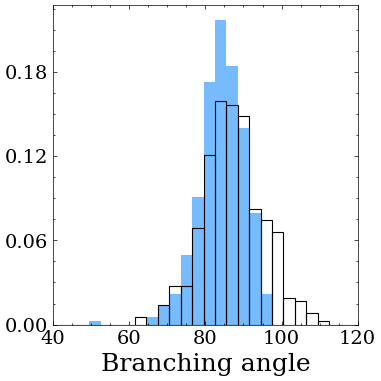

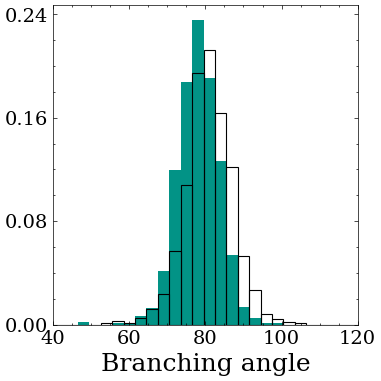

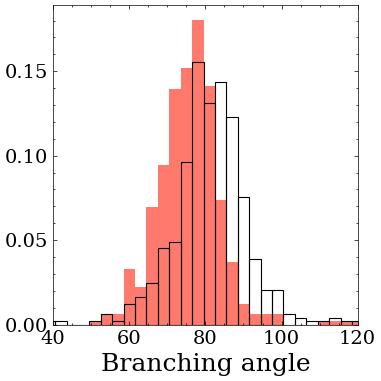

In [1073]:
feag=['withb_br_angle','nob_br_angle']
bin_num=60
for bi,b_type in enumerate(btype):
    data=brbfeas[brbfeas.brain_region==b_type]
    # bin_width=data[feag].max().max()/bin_num
    bin_width=3
    fig = plt.figure(figsize=(4,4),dpi=100)
    ax=plt.subplot(111)
    with_hit=fea_hist(indf=data,fea=feag[0],bin_width=bin_width,bin_num=bin_num)
    without_hit=fea_hist(indf=data,fea=feag[1],bin_width=bin_width,bin_num=bin_num)
    ax.bar(x=np.arange(1,bin_num+1)*bin_width,height=with_hit,width=bin_width,color=bcolors[bi],label='With bouton branch',fill=True)
    ax.bar(x=np.arange(1,bin_num+1)*bin_width,height=without_hit,width=bin_width,color='w',label='Without bouton branch',fill=False)
    # plt.legend(fontsize=12,loc='upper left')
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_major_locator(MaxNLocator(4))
    # ax.set_yticklabels([str((c+1)*0.25) for c in np.arange(split_num)])
    plt.xlabel('Branching angle',fontsize=fs)
    plt.ylabel('Density',fontsize=fs)
    plt.xlim([40,120])
    # plt.title(b_type,fontsize=14)
    plt.tight_layout()
    plt.show()
    fig.savefig('./figs/'+b_type+'_branching_angle_hist.png',dpi=300)

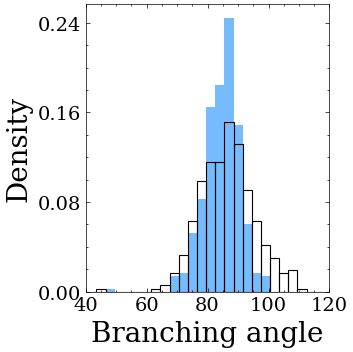

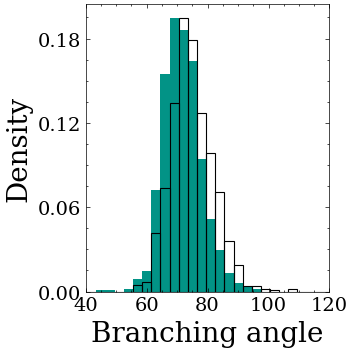

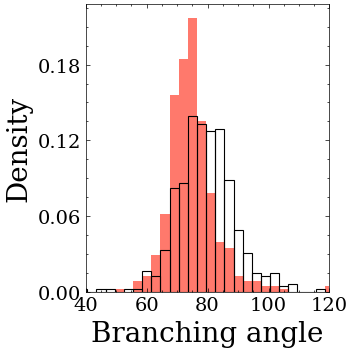

In [1140]:
feag=['withb_br_rangle','nob_br_rangle']
bin_num=60
for bi,b_type in enumerate(btype):
    data=brbfeas[brbfeas.brain_region==b_type]
    # bin_width=data[feag].max().max()/bin_num
    bin_width=3
    fig = plt.figure(figsize=(4,4),dpi=100)
    ax=plt.subplot(111)
    with_hit=fea_hist(indf=data,fea=feag[0],bin_width=bin_width,bin_num=bin_num)
    without_hit=fea_hist(indf=data,fea=feag[1],bin_width=bin_width,bin_num=bin_num)
    ax.bar(x=np.arange(1,bin_num+1)*bin_width,height=with_hit,width=bin_width,color=bcolors[bi],label='With bouton branch',fill=True)
    ax.bar(x=np.arange(1,bin_num+1)*bin_width,height=without_hit,width=bin_width,color='w',label='Without bouton branch',fill=False)
    # plt.legend(fontsize=12,loc='upper left')
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_major_locator(MaxNLocator(4))
    # ax.set_yticklabels([str((c+1)*0.25) for c in np.arange(split_num)])
    plt.xlabel('Branching angle',fontsize=fs)
    plt.ylabel('Density',fontsize=fs)
    plt.xlim([40,120])
    # plt.title(b_type,fontsize=14)
    plt.tight_layout()
    plt.show()
    fig.savefig('./figs/'+b_type+'_branching_remote_angle_hist.png',dpi=300)

## Visualization

In [234]:
def plot_mst_tree(inswc,direction='XY',title_text=None):
    # topo_bswc=nmt.swc.neuron(swc).swc
    df=inswc[['x','y','z']].copy()
    X = sklearn.metrics.pairwise_distances(df)
    Tscr = minimum_spanning_tree(X).toarray()
    # wire_length_raw = get_swc_total_len(inswc)
    # wire_length_mst = np.sum(Tscr)
    # wire_efficiency = wire_length_mst / wire_length_raw
    Tscr_df=pd.DataFrame(Tscr)
    Tscr_df[Tscr_df>0]=1
    df.reset_index(drop=False,inplace=True)
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    #plot mst
    for n in Tscr_df.index:
        for c in Tscr_df.keys():
            x1=[]
            x2=[]
            x3=[]
            if Tscr_df.loc[n,c]==0:
                continue
            x1.append(df.loc[n,'x'])
            x1.append(df.loc[c,'x'])
            x2.append(df.loc[n,'y'])
            x2.append(df.loc[c,'y'])
            x3.append(df.loc[n,'z'])
            x3.append(df.loc[c,'z'])
            # print(x1,x2)
            if direction=='YZ':
                ax.plot(x2,x3,c='red')
            elif direction=='XZ':
                ax.plot(x1,x3,c='red')
            else:
                ax.plot(x1,x2,c='red')
    ax.invert_yaxis()
    # if title_text==None:
    #     title_text=('Minimum spanning tree length=%.2fmm' % (wire_length_mst/1000))
    # elif title_text=='wiring':
    #     title_text=('Wiring efficiency =%.2f' % (wire_efficiency))
    # ax.set_title(title_text)   
    return fig, ax
def plot_bouton_mst_tree(inswc,direction='XY',
                         topath=None,title_text=None,
                         rid=None,linewidth=3,alpha=1,
                         soma_marker=100,bouton_marker=20,
                         bc='#fffe7a',lc='#ff796c',bec='#d8dcd6',
                         scale_bar=True,dpi=200,basic_width=3):
    # topo_bswc=nmt.swc.neuron(swc).swc
    direction_list=['XY','YZ','XZ','ALL']
    if direction.upper() not in direction_list:
        print('input is valid : direction=',direction)
        return None
    if rid is None:
        rid=get_rid(swc=inswc)
    soma=inswc.loc[rid,:]
    swc=inswc[(inswc.type>=5)|(inswc.type==1)].copy()
    df=swc[['x','y','z']].copy()
    X = sklearn.metrics.pairwise_distances(df)
    Tscr = minimum_spanning_tree(X).toarray()
    Tscr_df=pd.DataFrame(Tscr)
    Tscr_df[Tscr_df>0]=1
    df.reset_index(drop=False,inplace=True)
    if direction=='ALL':
        for d in np.arange(3):
            fig, ax = plt.subplots(1,1, figsize=(basic_width,basic_width),dpi=dpi)
            for n in Tscr_df.index:
                for c in Tscr_df.keys():
                    x1=[]
                    x2=[]
                    x3=[]
                    if Tscr_df.loc[n,c]==0:
                        continue
                    x1.append(df.loc[n,'x'])
                    x1.append(df.loc[c,'x'])
                    x2.append(df.loc[n,'y'])
                    x2.append(df.loc[c,'y'])
                    x3.append(df.loc[n,'z'])
                    x3.append(df.loc[c,'z'])
                    # print(x1,x2)
                    if direction_list[d].upper()=='YZ':
                        ax.plot(x2,x3,c=lc,linewidth=linewidth,alpha=alpha)
                        ax.scatter(x2, x3,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.2)
                        ax.scatter(soma['y'], soma['z'],s=soma_marker,c='black',label='soma')
                    elif direction_list[d].upper()=='XZ':
                        ax.plot(x1,x3,c=lc,linewidth=linewidth,alpha=alpha)
                        ax.scatter(x1, x3,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.2)
                        ax.scatter(soma['x'], soma['z'],s=soma_marker,c='black',label='soma')
                    else:
                        ax.plot(x1,x2,c=lc,linewidth=linewidth,alpha=alpha)
                        ax.scatter(x1, x2,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.2)
                        ax.scatter(soma['x'], soma['y'],s=soma_marker,c='black',label='soma')
            if scale_bar:
                x_len=100
                scale_len=math.floor(x_len*(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width))*25
                xshift=(ax.get_xlim()[1]-ax.get_xlim()[0])/2
                sbar_startx=ax.get_xlim()[1]-xshift-(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width/x_len)
                sbar_endx=ax.get_xlim()[1]-xshift
                sbar_y=ax.get_ylim()[0]+2
                ax.plot([sbar_startx,sbar_endx],[sbar_y,sbar_y],c='black',linewidth=2)
                ax.text(sbar_startx-5,sbar_y-20,str(round(scale_len,2))+'$\mu$m',fontsize=8)
            ax.set_axis_off()
            if title_text is not None:
                ax.set_title(title_text[d])
            if topath is not None:
                fig.savefig(topath[d],dpi=300)
    else:
        fig, ax = plt.subplots(1,1, figsize=(basic_width,basic_width),dpi=dpi)
        for n in Tscr_df.index:
            for c in Tscr_df.keys():
                x1=[]
                x2=[]
                x3=[]
                if Tscr_df.loc[n,c]==0:
                    continue
                x1.append(df.loc[n,'x'])
                x1.append(df.loc[c,'x'])
                x2.append(df.loc[n,'y'])
                x2.append(df.loc[c,'y'])
                x3.append(df.loc[n,'z'])
                x3.append(df.loc[c,'z'])
                # print(x1,x2)
                if direction.upper()=='YZ':
                    ax.plot(x2,x3,c=lc,linewidth=linewidth,alpha=alpha)
                    ax.scatter(x2, x3,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.1)
                    ax.scatter(soma['y'], soma['z'],s=soma_marker,c='black',label='soma')
                elif direction.upper()=='XZ':
                    ax.plot(x1,x3,c=lc,linewidth=linewidth,alpha=alpha)
                    ax.scatter(x1, x3,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.1)
                    ax.scatter(soma['x'], soma['z'],s=soma_marker,c='black',label='soma')
                else:
                    ax.plot(x1,x2,c=lc,linewidth=linewidth,alpha=alpha)
                    ax.scatter(x1, x2,s=bouton_marker,c=bc,label='bouton',edgecolors=bec,linewidths=0.1)
                    ax.scatter(soma['x'], soma['y'],s=soma_marker,c='black',label='soma')
        if scale_bar:
            x_len=100
            scale_len=math.floor(x_len*(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width))*25
            xshift=(ax.get_xlim()[1]-ax.get_xlim()[0])/2
            sbar_startx=ax.get_xlim()[1]-xshift-(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width/x_len)
            sbar_endx=ax.get_xlim()[1]-xshift
            sbar_y=ax.get_ylim()[1]-1
            ax.plot([sbar_startx,sbar_endx],[sbar_y,sbar_y],c='black',linewidth=2)
            ax.text(sbar_startx-2,sbar_y+6,str(round(scale_len,2))+'$\mu$m',fontsize=16)
        ax.set_axis_off()
        if title_text is not None:
            ax.set_title(title_text)
        if topath is not None:
            fig.savefig(topath,dpi=300)            
    return Tscr_df

In [231]:
def get_mean_neuron(indata,mean_feas,type='VPM'):
    indf=indata[indata.brain_region==type].copy()
    cmpfeas=mean_feas.keys().to_list()
    indf['dist2mean']=[(abs(mean_feas.loc[type,cmpfeas]-indf.loc[cell,cmpfeas])).sum() for cell in indf.index]
    indf.sort_values(by='dist2mean',inplace=True)
    return indf['dist2mean']
showdata=allfeas_df_s.copy()
showdata['soma_region']=[morpho_feas.loc[n,'soma_region'] for n in showdata.index]
showdata=showdata[showdata.soma_region.isin(ana_regions)].copy()
# brbfeas.loc[:,'brain_region']= 'Other'
showdata.loc[showdata['soma_region'].isin(CNU),'brain_region']= 'CNU'
showdata.loc[showdata['soma_region'].isin(CTX),'brain_region']= 'CTX'
showdata.loc[showdata['soma_region'].isin(TH),'brain_region']= 'TH'
meanfea_data=showdata.groupby(['brain_region']).mean()
outdf=get_mean_neuron(indata=showdata,mean_feas=meanfea_data,type='CTX')
outdf

name
18869_4054_x19963_y5080      4.585289
18864_2520_x2913_y22642      4.675968
18869_4302_x23433_y9053      4.684083
pre_18864_00153              4.691649
18869_3857_x22137_y7268      4.751458
                              ...    
191807_3532_x4912_y7973     31.718014
191812_5411_x6011_y24641    32.669966
17109_2401_x9695_y9693      32.802938
17109_2601_x10213_y8783     39.981259
191812_5221_x9028_y25900    47.612921
Name: dist2mean, Length: 526, dtype: float64

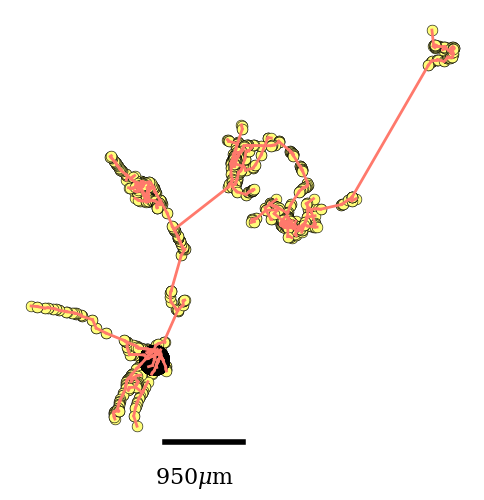

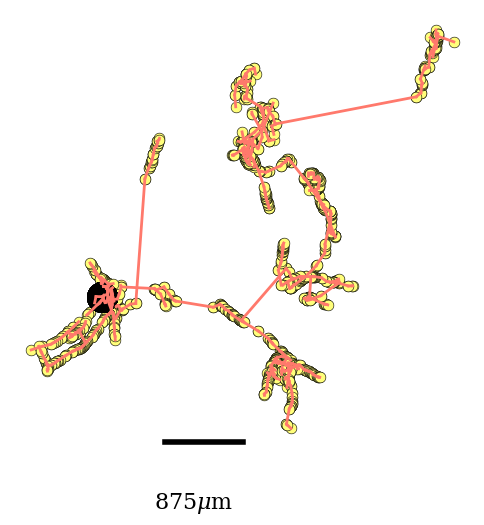

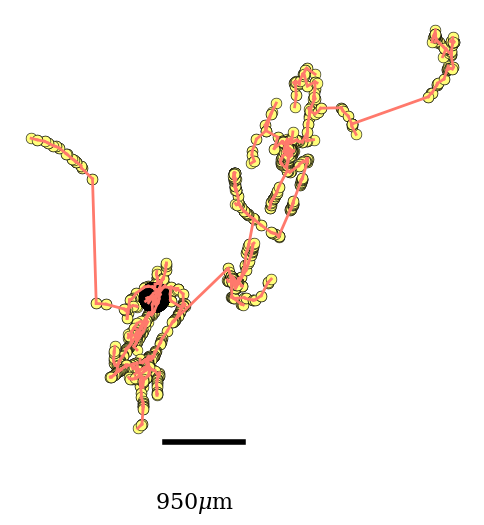

In [235]:
### get bouton data for MST
show_cell='18869_4054_x19963_y5080.eswc'
tf=os.path.join(out_fea_path,show_cell)
swc=readswc(file=tf,header=rheader,skiprows=1)
mst=plot_bouton_mst_tree(swc,direction='ALL',
                     bouton_marker=15,linewidth=1,
                     bec='black',lc='#ff796c',
                     topath=['./figs/'+d+show_cell+'_mst.png' for d in ['XY','YZ','XZ']])

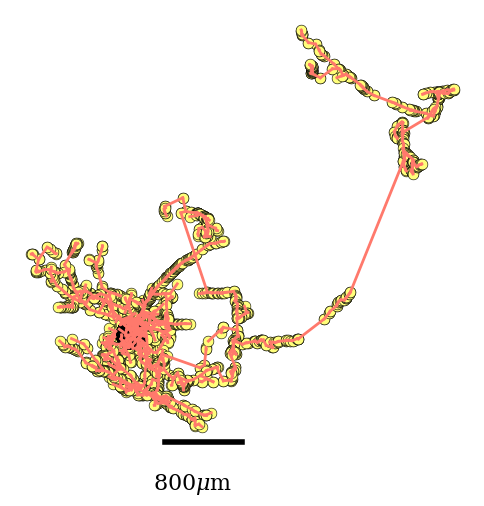

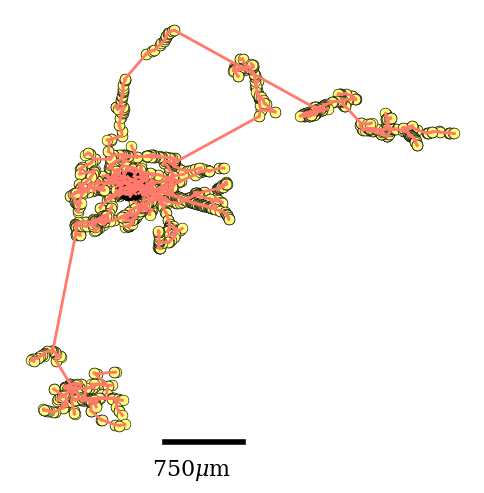

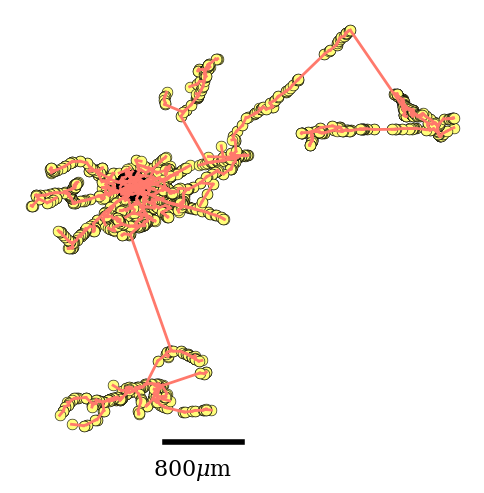

In [236]:
show_cell='18864_2520_x2913_y22642.eswc'
tf=os.path.join(out_fea_path,show_cell)
swc=readswc(file=tf,header=rheader,skiprows=1)
mst=plot_bouton_mst_tree(swc,direction='ALL',
                     bouton_marker=15,linewidth=1,
                     bec='black',lc='#ff796c',
                     topath=['./figs/'+d+show_cell+'_mst.png' for d in ['XY','YZ','XZ']])

In [1260]:
def hex_to_rgb(hex):
  return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))
def bouton_to_marker(inswc,rgb,teb_rgb,shift=1,topath=None):
    epb=inswc[inswc.type==5].copy()
    teb=inswc[inswc.type==6].copy()
    # axon=inswc[inswc.type==5].copy()
    if epb.shape[0]>0:
      epb_markers=pd.DataFrame()
      epb_markers['##x']=epb['x']+shift
      epb_markers['y']=epb['y']+shift
      epb_markers['z']=epb['z']+shift
      epb_markers.loc[:,'radius']=0
      epb_markers.loc[:,'shape']=1
      epb_markers.loc[:,'name']='EPB'
      epb_markers.loc[:,'comment']='Bouton'
      epb_markers.loc[:,'color_r']=int(rgb[0])
      epb_markers.loc[:,'color_g']=int(rgb[1])
      epb_markers.loc[:,'color_b']=int(rgb[2])
    if teb.shape[0]>0:
      teb_markers=pd.DataFrame()
      teb_markers['##x']=teb['x']+shift
      teb_markers['y']=teb['y']+shift
      teb_markers['z']=teb['z']+shift
      teb_markers.loc[:,'radius']=0
      teb_markers.loc[:,'shape']=1
      teb_markers.loc[:,'name']='EPB'
      teb_markers.loc[:,'comment']='Bouton'
      teb_markers.loc[:,'color_r']=int(teb_rgb[0])
      teb_markers.loc[:,'color_g']=int(teb_rgb[1])
      teb_markers.loc[:,'color_b']=int(teb_rgb[2])
    if epb.shape[0]>0 and teb.shape[0]>0:
      boutons=pd.concat([epb_markers,teb_markers],axis=0,ignore_index=True)
    elif epb.shape[0]>0 or teb.shape[0]>0:
      boutons=epb_markers.copy()
    else:
      return None
    if topath is not None:
      boutons.to_csv(topath,index=False,float_format='%.2f')
    return boutons